# ML Models to Predict Jumps in Ethereum Cryptocurrency Price Minute to Minute #

## Introduction

Despite the broad debate on digital currencies' implications, in recent years, the market for cryptocurrencies has expanded significantly in terms of transaction volumes, market capitalization, and the number of existent cryptos. However, this expansion has created highly volatile prices.

Based on the efficient market hypothesis, one could argue that it is impossible to predict prices of publicly traded assets, since investors would exploit any miss-price until the opportunity for a profit disappears. However, in the context of high-frequency trading, there is the possibility that some of these miss-prices do not get corrected due to the short time between observations. Thus an opportunity for a statistical arbitrage arises.

This project intends to implement three machine learning algorithms aimed at trying to find a prediction edge, exploiting these miss-prices, which could lead to a trading strategy that consistently makes money. To do so, we have decided to follow two approaches, either trying to predict the type of movement in the price (namely, a discrete response, either binary of quintiles) or the amount by which the price is modified (i.e., a continuous response) the next minute. 

## Data

The bulk of our historical observations comes from a Kaggle project [400+ crypto currency pairs at 1-minute resolution](https://www.kaggle.com/datasets/tencars/392-crypto-currency-pairs-at-minute-resolution), which in turn was sourced from the Bitfinex exchange API. It contains data from 2013 to 2023 for various cryptos, each at one-minute resolution.

We have also decided to source some additional information that may aid in the prediction, and the final data we will be using consists of the following:

* Close prices of Ethereum, as they will provide us with a tendency.
* Close prices of a small set of cryptocurrencies other than Ethereum, as the crypto market is highly interconnected, as posited in the Federal Reserve Bank of Chicago article [How Interconnected Are Cryptocurrencies and What Does This Mean for Risk Measurement?](https://www.chicagofed.org/publications/chicago-fed-letter/2022/466). Thus, the behavior of other digital currencies can be an excellent indicator of the behavior of Ethereum.
* Fama-French 5 factors.
* S&P 500.
* CMC Crypto 200 Index.
* Dow Jones Industrial Average.
* Russel 2000.

The additional cryptos will be taken for the database we already have. At the same time, the Fama-French 5 factors will be gathered directly from [Kenneth R. French website](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/index.html) and the indexes from Yahoo Finance.

The following Google Drive link has the data used on this notebook, which can only be accessed with a UW account.

[Final Datasets](https://drive.google.com/drive/folders/1_XDBuiD9cUbykGLLZCGXVwcPyq0qi1_Q?usp=share_link)

The approaches that this project will address and which member will be in charge are:

* Random Forests - Sofia Gray
* Support Vector Machines - Saraí Ramirez
* Neural Networks - Martin de Leon

## Selection of Features and Timeframe for the Analysis

On May 16, Forbes Advisor published the article [Top 10 Cryptocurrencies Of 2023](https://www.forbes.com/advisor/investing/cryptocurrency/top-10-cryptocurrencies), where the following cryptocurrencies are stated as the best of this year based on their market capitalization or the total value of all the coins currently in circulation:

1. Bitcoin (BTC)
2. Ethereum (ETH)
3. Tether (USDT)
4. Binance Coin (BNB)
5. U.S. Dollar Coin (USDC)
6. XRP (XRP)
7. Cardano (ADA)
8. Dogecoin (DOGE)
9. Solana (SOL)
10. Polygon (MATIC)

The data sets obtained in Kaggle do not contain Binance Coin or U.S. Dollar Coin, so those are discarded. We want to find the optimal number to add as supporting features among the remaining coins, yet we do not want to include all due to efficiency concerns. We also want to choose the optimal timeframe, which includes the most amount of information. Thus, we have decided to pre-analyze the number of missing observations and correlations of all these coins with Ethereum.

### Missing Data Analysis

In [1]:
#loading all base libraries
import numpy as np
import pandas as pd
import os
import warnings

In [2]:
#Loading the coins database (database created merging all coins)
os.chdir('/Users/martindl/Documents/3rd Quarter/CFRM 521/Homework/Final Project')
data = pd.read_csv("database.csv")

#Set the index as datetime
data['time'] = pd.to_datetime(data['time'], unit='ms')
data = data.set_index('time')

#Computing a quick missing data analysis
Start = ["2022-01", "2022-01", "2022-06", "2023-01"]
End = ["2022-12", "2022-06", "2022-12", "2023-05"]

for j,k in zip(Start,End):
    print("Start = {}, End = {}\n".format(j, k))
    coin = data.loc[data['eth_price'].dropna().index].loc[j:k]
    miss_perc = (coin.isnull().sum()/coin.isnull().count())
    print(pd.DataFrame(miss_perc.loc[['btc_price', 'ust_price', 'xrp_price', 'ada_price',
                                     'doge_price', 'sol_price', 'matic_price']].sort_values()).transpose().set_index(pd.Index(['eth_price'])))
    print("N of obs = {}".format(coin.isnull().count()[0]))
    print("Avg missing obs = {}".format(miss_perc.loc[['btc_price', 'ust_price', 'xrp_price', 'ada_price',
                                     'doge_price', 'sol_price', 'matic_price']].sort_values().mean()))
    print("\n")

Start = 2022-01, End = 2022-12

           btc_price  ust_price  xrp_price  ada_price  sol_price  doge_price  \
eth_price   0.005723   0.094347   0.152495   0.296644   0.362397         1.0   

           matic_price  
eth_price          1.0  
N of obs = 521406
Avg missing obs = 0.4159437586613338


Start = 2022-01, End = 2022-06

           btc_price  ust_price  xrp_price  ada_price  sol_price  doge_price  \
eth_price   0.002462   0.084651    0.10483   0.190373   0.273419         1.0   

           matic_price  
eth_price          1.0  
N of obs = 257894
Avg missing obs = 0.3793906466554919


Start = 2022-06, End = 2022-12

           btc_price  ust_price  xrp_price  ada_price  sol_price  doge_price  \
eth_price   0.007768   0.098127   0.193664   0.366228   0.420908         1.0   

           matic_price  
eth_price          1.0  
N of obs = 305359
Avg missing obs = 0.44095638248749836


Start = 2023-01, End = 2023-05

           btc_price  ust_price  xrp_price  sol_price  ada_price  d

In [3]:
#Selecting the coins
data_red = data.loc[data['eth_price'].dropna().index].loc['2022'][['eth_price', 'btc_price', 'ust_price', 'xrp_price', 'ada_price', 'sol_price']]

#Correlations for differences
data_red.diff().corr()

,eth_price,btc_price,ust_price,xrp_price,ada_price,sol_price
eth_price,1.000000,0.816073,-0.027229,0.616726,0.629283,0.632791
btc_price,0.816073,1.000000,-0.023617,0.622133,0.628533,0.615143
ust_price,-0.027229,-0.023617,1.000000,-0.025240,-0.027820,-0.030699
xrp_price,0.616726,0.622133,-0.025240,1.000000,0.564415,0.560081
ada_price,0.629283,0.628533,-0.027820,0.564415,1.000000,0.605780
sol_price,0.632791,0.615143,-0.030699,0.560081,0.605780,1.000000


On the missing data analysis, we took all the timestamps with Ethereum observations for different timeframes, and joined them with the other coins to find the percentage of missing data points. It would appear that DOGE and MATIC do not have enough observation, so we have decided to discard them. Then, the comparison would be between using just the first semester of 2022 and all of 2022. We believe that by using all of 2022, we will have more information for the model, though in training we may switch to just using the first semester depending on how slow the training is.

Next, we computed correlations. Recall that we are interested in the movements of a cryptocurrency from minute to minute, not in the price itself, so we will use the `diff()` function, which computes the value change between two consecutive elements. Hence, we will calculate the correlation between those differences.

Notice that we are not filling in the missing values. Since we are working with time series, we will need to fill down to deal with missings. This process could bias the correlation of our currencies (which depends on the element-wise and pair-wise expectation); given that we do not need all observations to exist at this point, we will not modify the missing values.

Bitcoin is the most correlated currency with Ethereum. Cardano, XRP, and Solana have similar correlations (around 61%), while USDT displays a low relevance (in terms of correlation) to Ethereum jumps.

Finally, based on both analyses, we chose **Bitcoin** and **XRP**. Including any additional coins may slow down training by too much, and these coins offer the best correlation and have the least amount of missing observations for all of 2022.

### Final feature selection

With all of this in mind, we started brainstorming possible features and transformations, and these are the final ones we will be implementing:

* Month of the year to account for a possible seasonality.
* Day of the week to account for a possible seasonality.
* 1-minute difference in the price of the previous 30 minutes for Ethereum, Bitcoin, and XRP
* 1-minute volume of the previous 30 minutes for Ethereum, Bitcoin, and XRP
* 1-minute difference between the close and open of the previous 30 minutes for Ethereum, Bitcoin, and XRP
* 1-minute difference between the high and low of the previous 30 minutes for Ethereum, Bitcoin, and XRP
* 1-minute difference between the high and close of the previous 30 minutes for Ethereum, Bitcoin, and XRP
* Daily Fama-French 5 factors, including the risk-free rate
* Daily differences in adjusted prices for S&P 500, CMC Crypto 200 Index, Dow Jones Industrial Average, Russel 2000.

We believe that all these features have merit in adding the prediction for Ethereum. For the dependent variable, we will be implementing the following three:

* Differences in prices for Ethereum - Continuous response
* Quintiles of the differences in prices for Ethereum - Multiclass classification response
* Binary for the positive and negative differences in prices for Ethereum - Binary classification response

These will be the base for the implementation. However, each team member has complete discretion in their own implementation, selecting one or more response variables, creating new features, or deleting others as they see fit.

##  Data Preparation

Now that we have defined the scope of the data, we can import everything and start the data preparation process.

In [4]:
#Define the directory of the final coins to include
os.chdir('/Users/martindl/Documents/3rd Quarter/CFRM 521/Homework/Final Project/Final Cryptos')

#Ethereum
eth = pd.read_csv("eth.csv")
eth['time'] = pd.to_datetime(eth['time'], unit='ms')
eth = eth.set_index('time')
eth = eth.loc['2022']

#Bitcoin
btc = pd.read_csv("btc.csv")
btc['time'] = pd.to_datetime(btc['time'], unit='ms')
btc = btc.set_index('time')
btc = btc.loc['2022']

#XRP
xrp = pd.read_csv("xrp.csv")
xrp['time'] = pd.to_datetime(xrp['time'], unit='ms')
xrp = xrp.set_index('time')
xrp = xrp.loc['2022']

In [5]:
#Setting up a column transformer that works for all three, to create the custom columns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

def substract(function_transformer, feature_names_in):
    return ["diff"]

def diff(X):
    return pd.DataFrame(X.iloc[:, 0] - X.iloc[:, 1])

def diff_pipe():
    return Pipeline([
    ("diff", FunctionTransformer(diff, feature_names_out = substract))
])

process_pipe = ColumnTransformer([
        ("close_open", diff_pipe(), ["close", "open"]),
        ("high_low", diff_pipe(), ["high", "low"]),
        ("high_close", diff_pipe(), ["high", "close"])
    ])

#Getting the transformed features, and dropping information not needed
eth_transform = eth.join(pd.DataFrame(process_pipe.fit_transform(eth), columns = process_pipe.get_feature_names_out(), index = eth.index)).drop(['open', 'high', 'low'], axis=1)
btc_transform = btc.join(pd.DataFrame(process_pipe.fit_transform(btc), columns = process_pipe.get_feature_names_out(), index = btc.index)).drop(['open', 'high', 'low'], axis=1)
xrp_transform = xrp.join(pd.DataFrame(process_pipe.fit_transform(xrp), columns = process_pipe.get_feature_names_out(), index = xrp.index)).drop(['open', 'high', 'low'], axis=1)

Using `pandas_datareader` to get the additional information through APIs:

In [6]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
warnings.filterwarnings("ignore")

#Fama-French 5 factors
ff_5f = (pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3_daily',start='2021-12',
                                 end='2022-12')[0]).fillna(method='ffill')

#Indexes
index_data = (pdr.get_data_yahoo(['^GSPC', '^CMC200', '^DJI', '^RUT'],
                                 start= '2021-12-30', end='2023-01-01')['Adj Close']).diff()

[*********************100%***********************]  4 of 4 completed


Now that we have all the data loaded, we need to compile everything together. We will be using the `ts_split` function shown in class to get the lagged data, and then combine everything, filling in the missing data using a simple fill-down method (we believe that for time series, this is the simplest method, and it makes sure we are not using future information).

For splitting into train, validation, and test, we have decided to use the following scheme:

* 80% of the data for training
* 10% of the data for validation
* 10% of the data for testing

In [7]:
#Defining the function ts_split
def ts_split(ts, feature_steps, target_steps=1):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)]).reshape(n_obs, -1, order='F')
    y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps]
                  for idx in range(n_obs)]).reshape(n_obs, -1, order='F')
    return X, y

#Joining all coins, filling nan and then taking the differences
eth_transform_2 = eth_transform.set_axis(["pdiff_eth", "volume_eth", "close_open_diff_eth", "high_low_diff_eth", "high_close_diff_eth"], axis=1)
btc_transform_2 = btc_transform.set_axis(["pdiff_btc", "volume_btc", "close_open_diff_btc", "high_low_diff_btc", "high_close_diff_btc"], axis=1)
xrp_transform_2 = xrp_transform.set_axis(["pdiff_xrp", "volume_xrp", "close_open_diff_xrp", "high_low_diff_xrp", "high_close_diff_xrp"], axis=1)

#Fill all NAs with fill down
coins_data = eth_transform_2.join(btc_transform_2, how='left').join(xrp_transform_2, how='left').fillna(method='ffill')

#Taking the differences and rejoining with the other features
coins_data = coins_data[['pdiff_eth', 'pdiff_btc', 'pdiff_xrp']].diff().iloc[1:].join(coins_data.drop(['pdiff_eth', 'pdiff_btc', 'pdiff_xrp'], axis = 1))

#Splitting the data
X, y = ts_split(coins_data, 30)

#Creating the column names
col_names = np.array([])
for i in coins_data.columns:
    col_names = np.append(col_names, [i+str(j-30) for j in range(30)])

#Starting X and y with the coins data    
X = pd.DataFrame(X, index=coins_data[30:].index, columns=col_names)
y = pd.Series(y[:,0], index=coins_data[30:].index)

#Adding the FF-5F and the indices
X = X.join(ff_5f, on=pd.to_datetime(X.index.date), how="left").join(index_data, on=pd.to_datetime(X.index.date), how="left")
X.loc['2022-01-01 00:34:00', ('Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF')] = np.array(ff_5f.loc["2021-12-31"]).ravel()
X.loc['2022-01-01 00:34:00', ('^CMC200', '^DJI', '^GSPC', '^RUT')] = np.array(index_data.loc["2021-12-31"]).ravel()

#Filling the nan for these new features
X = X.fillna(method='ffill')

#Using OHE to create the month and week features
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False)
month = pd.DataFrame(ohe.fit_transform(np.array(y.index.month).reshape(-1, 1)), columns=['jan','feb','mar','apr','may','june', 'jul', 'aug', 'sept', 'oct', 'nov', 'dec'])
weekday = pd.DataFrame(ohe.fit_transform(np.array(y.index.weekday).reshape(-1, 1)), columns=['mon','tue','wed','thu','fri ','sat','sun'])

#Joining these OHE features
X = X.join(month.set_axis(X.index)).join(weekday.set_axis(X.index))

#Creating binary problem
y_binary = (y > 0)*1

#Getting the index for splitting
index_train = X.iloc[int(np.ceil(len(y)*0.8))].name
index_valid = X.iloc[int(np.ceil(len(y)*0.9))].name

#Train split
X_train = X.loc[:index_train]
y_train = y.loc[:index_train]

#Creating classification problem based on the train set
conditions = [
    (y <= y_train.quantile(0.2)),
    (y > y_train.quantile(0.2)) & (y <= y_train.quantile(0.4)),
    (y > y_train.quantile(0.4)) & (y <= y_train.quantile(0.6)),
    (y > y_train.quantile(0.6)) & (y <= y_train.quantile(0.8)),
    (y > y_train.quantile(0.8))
    ]
values = [0,1,2,3,4]

y_class = pd.Series(np.select(conditions, values), index=y.index)

#Train split classification
y_class_train = y_class.loc[:index_train]
y_binary_train = y_binary.loc[:index_train]

#Validation split
X_valid = X.loc[index_train:index_valid]
y_valid = y.loc[index_train:index_valid]
y_class_valid = y_class.loc[index_train:index_valid]
y_binary_valid = y_binary.loc[index_train:index_valid]

#Test split
X_test = X.loc[index_valid:]
y_test = y.loc[index_valid:]
y_class_test = y_class.loc[index_valid:]
y_binary_test = y_binary.loc[index_valid:]

With the data preprocessing finished, we can print the dimensions of each X:

In [8]:
print("The shape of the full dataset is: ",X.shape)
print("\nThe shape of the training set is: ",X_train.shape)
print("\nThe shape of the validation set is: ",X_valid.shape)
print("\nThe shape of the test set is: ",X_test.shape)

The shape of the full dataset is:  (521375, 479)

The shape of the training set is:  (417101, 479)

The shape of the validation set is:  (52139, 479)

The shape of the test set is:  (52137, 479)


### Classes Analysis

In classification, class unbalances could cause problems in training, as well as problems in various metrics (accuracy being especially susceptible to this). Thus, we have decided to present the class distribution in an attempt to identify possible problems in our implementations associated with this phenomenon.

In [9]:
#Classification Classes
shape_classes = np.column_stack([y_class.value_counts().sort_index()/y_class.count() * 100,
                                 y_class_train.value_counts().sort_index()/y_class_train.count() * 100,
                                 y_class_valid.value_counts().sort_index()/y_class_valid.count() * 100,
                                 y_class_test.value_counts().sort_index()/y_class_test.count() * 100])
pd.DataFrame(shape_classes, index=range(5), columns=['Full', 'Train', 'Valid', 'Test'])

,Full,Train,Valid,Test
0,17.352194,20.000192,11.344675,2.176957
1,20.416591,20.402732,22.829360,18.113816
2,24.990266,19.668378,32.656936,59.897961
3,19.871494,19.928746,21.793667,17.492376
4,17.369456,19.999952,11.375362,2.318891


In [10]:
#Classification binary
shape_binary = np.column_stack([y_binary.value_counts().sort_index()/y_binary.count() * 100,
                                 y_binary_train.value_counts().sort_index()/y_binary_train.count() * 100,
                                 y_binary_valid.value_counts().sort_index()/y_binary_valid.count() * 100,
                                 y_binary_test.value_counts().sort_index()/y_binary_test.count() * 100])
pd.DataFrame(shape_binary, index=range(2), columns=['Full', 'Train', 'Valid', 'Test'])

,Full,Train,Valid,Test
0,52.606665,51.7268,53.833023,58.419165
1,47.393335,48.2732,46.166977,41.580835


## Simple Benchmarks

We decided to compute some simple benchmarks to compare with our models to determine their usefulness. They consist of predicting the response variable t+1 as the observation t. For each one of our approaches:

- On the continuous response variable, if we observe that the difference between the price of the previous minute (t-1) and this minute (t) is 2 dollars, then for t+1, we predict that there will be an increase of 2 dollars again.

- On the multi-class classification, if we observe a difference included in class 2 on time t, then we predict class 2 again for t+1

- On the binary classification, if we observe class 0 on time t (a negative difference in price from t-1 to t), we predict class 0 (that the price will again go down in the next minute)

Another plausible approach for classification would have been predicting everything as the most common class on the train set. However, we decided against this due to the unbalanced nature of the classes in the test set, which could result in a strong benchmark for this particular dataset, but one that would not hold in other years not included in this report.

In [43]:
#Predicting t-1 as t
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

y_pred_t_1 = y.iloc[int(np.ceil(len(y)*0.9))-1:y.size - 1]

rmse = np.sqrt(mean_squared_error(y_test, y_pred_t_1))

y_class_pred_t_1 = y_class.iloc[int(np.ceil(len(y)*0.9))-1:y.size - 1]

accuracy_class = accuracy_score(y_class_test, y_class_pred_t_1)

y_binary_pred_t_1 = y_binary.iloc[int(np.ceil(len(y)*0.9))-1:y.size - 1]

accuracy_binary = accuracy_score(y_binary_test, y_binary_pred_t_1)

print("Benchmarks to beat:")

pd.DataFrame([rmse, accuracy_class, accuracy_binary], index=["Regression", "Classification - Multi-class", "Classification - Binary"], columns=["RMSE / Accuracy"])

Benchmarks to beat:


,RMSE / Accuracy
Regression,1.074030
Classification - Multi-class,0.481290
Classification - Binary,0.512918


Particularly for the binary classification, we decided to compute a classification report, since accuracy itself might not be a reliable benchmark. Precision, recall, and F1 score for each class paint a more complete picture, which could aid in assessing the usefulness of the models.

In [46]:
from sklearn.metrics import classification_report

print("Classification report for binary target Benchmark: \n\n",classification_report(y_binary_test, y_binary_pred_t_1))

Classification report for binary target Benchmark: 

               precision    recall  f1-score   support

           0       0.58      0.58      0.58     30458
           1       0.41      0.41      0.41     21679

    accuracy                           0.51     52137
   macro avg       0.50      0.50      0.50     52137
weighted avg       0.51      0.51      0.51     52137



## Random Forest Implementation - Sofia Gray


### Regression

For the random forest implementation, I decided to implement a regression and a binary classification. Some of the reasons I decided to use a random forest approach are

* Random forest models can handle large data sets more efficiently
* Usually provides a higher level of accuracy than decision trees and other algorithms
* Does not overfit the model with more features

To tune the model, I chose to test the performance of the model on three different hyperparameters: the number of estimators in the tree, the maximum number of features, and the minimal cost-complexity pruning alpha. The set of values that were used to tune the hyperparameters are

* `n_estimators`: {100, 200, 300, 400, 500}
* `max_features`: {50, 150, 250, 350, 450}
* `ccp_alpha`: $ \left \{ 10^{-2}, ..., 10^{-6} \right \} $

#### Simple Model

I first decided to train and evaluate a simple model with no hyperparameter tuning to compare the performance to a tuned model. The simple model consists of a random forest regressor using the default hyperparameter arguments and was trained on the full training set and then evaluated on the full testing set.

In [ ]:
rf_reg_sim = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_reg_sim.fit(X_train, y_train.ravel())

y_pred_reg_sim = rf_reg_sim.predict(X_valid)

rf_rmse_sim = np.sqrt(mean_squared_error(y_valid, y_pred_reg_sim))
rf_rmse_sim

1.8075369334561031

The simple model yielded an RMSE of 1.81. This is relatively higher than our benchmark RMSE of 1.07. Therefore, the simple model is not a good model relative to the benchmark. 

#### Model Selection

Next, we tune the model to improve performance. In order to tune the model and reduce computation time, I took a random sample of 5% from both the training set and validation set.

In [ ]:
train_index_rand = np.sort(np.random.choice(X_train.shape[0], int(np.ceil(X_train.shape[0] * 0.05)), replace=False))

X_train_red = X_train.iloc[train_index_rand,:]
y_train_red = y_train.iloc[train_index_rand]   

In [ ]:
valid_index_rand = np.sort(np.random.choice(X_valid.shape[0], int(np.ceil(X_valid.shape[0] * 0.05)), replace=False))

X_valid_red = X_valid.iloc[valid_index_rand,:]
y_valid_red = y_valid.iloc[valid_index_rand]

The random sample of the training set was used to train the models from all possible combinations of the hyperparameters while the random sample of the validation set was used to evaluate the performance of all these models.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, f1_score
import random

In [ ]:
n_estimators_list = [100, 200, 300, 400, 500]
max_features_list = [50, 150, 250, 350, 450]
ccp_alpha_list = [10**-k for k in range(1, 6)]

rf_rmse = []

for n_estimators in n_estimators_list:
    for ccp_alpha in ccp_alpha_list:
        for max_features in max_features_list: 
            rf_reg = RandomForestRegressor(random_state=42, ccp_alpha=ccp_alpha, n_estimators=n_estimators, max_features=max_features, n_jobs=-1)
            rf_reg.fit(X_train_red, y_train_red.ravel())
            y_pred_reg = rf_reg.predict(X_valid_red)
            rf_rmse.append(np.sqrt(mean_squared_error(y_valid_red, y_pred_reg)))

Here, we print the RMSE of all 125 models that were trained and evaluated.

In [ ]:
ind = 0
for n_estimators in n_estimators_list:
    for ccp_alpha in ccp_alpha_list:
        for max_features in max_features_list:
            print(rf_rmse[ind])
            print(["(ccp_alpha, n_estimators, max_features):",[ccp_alpha, n_estimators, max_features]])
            ind += 1

1.8346801229023695
['(ccp_alpha, n_estimators, max_features):', [0.1, 100, 50]]
1.8243392024376033
['(ccp_alpha, n_estimators, max_features):', [0.1, 100, 150]]
1.8282881750649806
['(ccp_alpha, n_estimators, max_features):', [0.1, 100, 250]]
1.8305615008935239
['(ccp_alpha, n_estimators, max_features):', [0.1, 100, 350]]
1.8300367162263733
['(ccp_alpha, n_estimators, max_features):', [0.1, 100, 450]]
1.8487274205042559
['(ccp_alpha, n_estimators, max_features):', [0.01, 100, 50]]
1.841120541766852
['(ccp_alpha, n_estimators, max_features):', [0.01, 100, 150]]
1.8370464733572105
['(ccp_alpha, n_estimators, max_features):', [0.01, 100, 250]]
1.848688624324582
['(ccp_alpha, n_estimators, max_features):', [0.01, 100, 350]]
1.8437465686759364
['(ccp_alpha, n_estimators, max_features):', [0.01, 100, 450]]
1.8570872286186055
['(ccp_alpha, n_estimators, max_features):', [0.001, 100, 50]]
1.8508040480763728
['(ccp_alpha, n_estimators, max_features):', [0.001, 100, 150]]
1.8362914164836193
['(cc

From the list of models above, we see that the best model has an RMSE of 1.8243392024376033, with an alpha of 0.1, 100 estimators, and 150 features. 

#### Tuned model

Now, we train the best model on the full training set and evaluate its performance on the test set. 

In [ ]:
best_model_reg = RandomForestRegressor(random_state=42, ccp_alpha=0.1, n_estimators=100, max_features=150, n_jobs=-1)
best_model_reg.fit(X_train, y_train.ravel())

y_pred_reg = best_model_reg.predict(X_test)
best_rmse = np.sqrt(mean_squared_error(y_test, y_pred_reg))
best_rmse

0.7513674615949594

The RMSE of the best tuned model is 0.75, which is a lot lower than the RMSE of our initial simple model, the RMSE's of all 125 models that were trained during hyperparameter tuning, and the RMSE of the benchmark. Therefore, we can conclude that the random forest regression is a good model. 

### Binary Classification

To reduce computation time and because the performance of the simple random forest regression model was a lot lower than the tuned model and did not provide any useful insights, we omit the training and evaluation of a simple model for the binary classification problem. Instead, we go straight into tuning the binary classification model.

The same set of hyperparameters stated earlier are being used here for the binary classification. Just like we did for the regression, a 5% random sample from the training set and validation set was used to train and evaluate all possible models across all hyperparameter combinations.  

#### Model Selection

In [ ]:
y_binary_train_red = y_binary_train.iloc[train_index_rand]   
y_binary_valid_red = y_binary_valid.iloc[valid_index_rand]

In [ ]:
rf_acc = []

for n_estimators in n_estimators_list:
    for ccp_alpha in ccp_alpha_list:
        for max_features in max_features_list: 
            rf_clf = RandomForestClassifier(random_state=42, ccp_alpha=ccp_alpha, n_estimators=n_estimators, max_features=max_features, n_jobs=-1)
            rf_clf.fit(X_train_red, y_binary_train_red.ravel())
            y_pred_clf = rf_clf.predict(X_valid_red)
            rf_acc.append(accuracy_score(y_binary_valid_red, y_pred_clf))

In [ ]:
ind = 0
for n_estimators in n_estimators_list:
    for ccp_alpha in ccp_alpha_list:
        for max_features in max_features_list: 
            print(rf_acc[ind])
            print(["(ccp_alpha, n_estimators, max_features):",[ccp_alpha, n_estimators, max_features]])
            ind += 1

0.55427694668201
['(ccp_alpha, n_estimators, max_features):', [0.1, 100, 50]]
0.55427694668201
['(ccp_alpha, n_estimators, max_features):', [0.1, 100, 150]]
0.55427694668201
['(ccp_alpha, n_estimators, max_features):', [0.1, 100, 250]]
0.55427694668201
['(ccp_alpha, n_estimators, max_features):', [0.1, 100, 350]]
0.55427694668201
['(ccp_alpha, n_estimators, max_features):', [0.1, 100, 450]]
0.55427694668201
['(ccp_alpha, n_estimators, max_features):', [0.01, 100, 50]]
0.55427694668201
['(ccp_alpha, n_estimators, max_features):', [0.01, 100, 150]]
0.55427694668201
['(ccp_alpha, n_estimators, max_features):', [0.01, 100, 250]]
0.55427694668201
['(ccp_alpha, n_estimators, max_features):', [0.01, 100, 350]]
0.55427694668201
['(ccp_alpha, n_estimators, max_features):', [0.01, 100, 450]]
0.55427694668201
['(ccp_alpha, n_estimators, max_features):', [0.001, 100, 50]]
0.55427694668201
['(ccp_alpha, n_estimators, max_features):', [0.001, 100, 150]]
0.55427694668201
['(ccp_alpha, n_estimators, m

The best model found during tuning had an accuracy of 0.56 or 56%, with an alpha of 0.00001, 100 estimators, and 50 features.

#### Tuned Model

Now, we train the best model on the full training set and evaluate its performance on the test set. 

In [ ]:
best_model_clf = RandomForestClassifier(random_state=42, ccp_alpha=0.00001, n_estimators=100, max_features=50, n_jobs=-1)
best_model_clf.fit(X_train, y_binary_train.ravel())

y_pred_clf = best_model_clf.predict(X_test)
best_acc = accuracy_score(y_binary_test, y_pred_clf)
best_acc

0.5814872355524867

We also calculate the f1 score and print the classification report to further evaluate the performance of the model compared to the benchmark. 

In [ ]:
f1_score(y_binary_test, y_pred_clf)

0.2529443987948507

In [ ]:
classification_report(y_binary_test, y_pred_clf)

'              precision    recall  f1-score   support\n\n           0       0.60      0.87      0.71     30458\n           1       0.49      0.17      0.25     21679\n\n    accuracy                           0.58     52137\n   macro avg       0.54      0.52      0.48     52137\nweighted avg       0.55      0.58      0.52     52137\n'

In [80]:
print('              precision    recall  f1-score   support\n\n           0       0.60      0.87      0.71     30458\n           1       0.49      0.17      0.25     21679\n\n    accuracy                           0.58     52137\n   macro avg       0.54      0.52      0.48     52137\nweighted avg       0.55      0.58      0.52     52137\n')

              precision    recall  f1-score   support

           0       0.60      0.87      0.71     30458
           1       0.49      0.17      0.25     21679

    accuracy                           0.58     52137
   macro avg       0.54      0.52      0.48     52137
weighted avg       0.55      0.58      0.52     52137



### Conclusion

Although both the regression and the binary classification approaches had a relatively high performance, the random forest regressor is the better of the two as it performed slightly better when comparing its performance measure RMSE to the accuracy of the binary classification.

The binary classification approach proved to be successful with an accuracy of 58%, which is higher than the benchmark accuracy of 51%. However, because the F1 score of 0.25 was significantly lower than the benchmark F1 score of 0.41. With the binary classification, while still useful in predicting whether the price of ethereum will increase or decrease, we cannot say with 100% certainty that it is not simply predicting most of the observations as the most frequent class as indicated by the low F1 score.

On the other hand, the random forest regression performed extremely well relative to the benchmark. The best model regression had an RMSE of 0.75, which is significantly better than the benchmark RMSE of 1.07. It also performed better than the simple model by a long stretch. The simple random forest regressor had a relatively high RMSE of 1.81.

The table below provides a summary of the hyperparameter values of the best model for both approaches along with the corresponding performance measure.

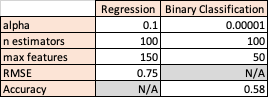

## SVM Implementation - Saraí Ramirez

This project is made up of three goals: regression, binary classification, and multi-label classification, which are supervised learning tasks. SVM is able to deal with these kind of problems, and the reasons why I selected this approach are:

* SVM is capable to deal with many dimensions (although I will work with a PCA-transormed dataset, it has still 28 features).
* SVM can model linear and non-linear decision boundaries; to take advantage of this property, the three approaches will be addressed with linear, polynomial, and RBF-Gaussian kernels.
* The built-in kernels allow us to explore several transformed features efficiently (although SVM and SVC are generally slow, using the kernel functions is more efficient than doing the same exploration "by hand"). Then, the approach provides an enormous flexibility.
* Because the decision boundaries are determined by the support vectors (the closest ones to the boundaries), SVM is robust to noise, implying SVM performs well with new and unseen data, and is not easily affected by outliers.
* SVM uses only a subset of training instances in the decision function (the support vectors). This is translated into (relative) memory and time efficiency.

Although aware that SVM does not excel with large datasets, and that, even with the facts that provide SVMs with a relative efficiency, SVM can be very slow, I decided to test its ability to handle scenarios like our problem, where the dataset is huge, and there are more instances than features by far (even witout the PCA transformation).

Previous to the implementation of the algorithms proposed below, a preliminary study was carried out. In this study, I learned that the three goals require a different preprocess for the data:

* Regression: The RMSE is not so different when used a PCA-transformed and the original dataset. Because a PCA-transformation allows managing fewer features, and therefore, more efficient processes, the transformed dataset will be used instead of the original one.
* Binary Classification: Three approaches were analyzed: Original dataset, PCA-transformed, and PCA-transformed concatenated with k-means-transformed data. Even though the corresponding accuracies are not so different to each other, applying a clustering process of k-means previous to the fit of the models ended up outperforming the other trials just by a little bit.
* Multi-label Classification: The same approaches as for binary classification were evaluated. Among them, the best one was the original dataset.

Besides the selected preprocessing methods, it was also evaluated applying only k-means and concatenating the original features to the k-means transformed data, but these techniques were less efficient than those chosen.

In order to find the best possible model for each target, I will analyze the performance of SVMs with linear, polynomial, and RBF Gaussian kernels; in turn, I will carry out a a cross-validation search to tune the hyperparameters `C`, `degree` for the polynomial kernel, and `gamma` for the RBF Gaussian kernel. The cross-validation search will rely on splitting into 3 subsets by a `TimeSeriesSplit` instance.

The set of values tried for the hyperparameters are:

* `C`: $ \left \{ 10^{-2}, ..., 10^{-7} \right \} $ for regression, and $ \left \{ 0.1, 1, 5, 10, 50 \right \} $ for both classifications
* `degree`: {2, 3, 4, 5}
* `gamma`: {0.1, 0.5, 1, 5, 10}

A subset of the training set will be used to tune the hyperparameters.

### Regression

#### Preprocess

Before fitting any model, the data will be transformed with a PCA to explain 95% of the variance. As shown below, only 28 features are necessary instead ot 479. Next, data will be standardized. The `pipeline_preprocess` will carry out both tasks.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [ ]:
pipeline_preprocess = Pipeline([
    ('PCA', PCA(n_components=0.95)),
    ('standardization', StandardScaler())
])

In [ ]:
X_pca = pipeline_preprocess.fit_transform(X_train)
X_test_pca = pipeline_preprocess.transform(X_test)

X_pca.shape

(417101, 28)

#### Model Selection

In [ ]:
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import LinearSVR, SVR, LinearSVC, SVC

In [ ]:
X_small = X_pca[:50000]
y_small = y_train[:50000]
y_binary_small = y_binary_train[:50000]
y_class_small = y_class_train[:50000]

split_series = TimeSeriesSplit(n_splits = 3)

reg_linear = LinearSVR(epsilon = 0.8, max_iter = 10000)
reg_poly = SVR(kernel = 'poly', max_iter = 10000)
reg_rbf = SVR(kernel = 'rbf', max_iter = 10000)

Function `tuning_regression(.)` is in charge of varying the corresponding hyperparameters according to the indicated kernel, train a model, and compute the RMSE for each hyperparameter configuration. The function will take in the test and validation sets of a single fold, and will return a list with the RMSEs of each setting. Function `folds_regression(.)` is fed by the desired kernel and a grid of parameters, obtains the RMSE for each fold (obtained through the `TimeSeriesSplit` instance), and returns the average across the three folds for each setting of hyperparameters.

In [ ]:
def tuning_regression(X_tfold, y_tfold, X_vfold, y_vfold, grid, kernel):
    rmse_list = []

    if 'linear' == kernel:
        for C in grid['C']:
            reg_linear.set_params(C = C)
            reg_linear.fit(X_tfold, y_tfold)
            y_pred = reg_linear.predict(X_vfold)
            rmse = mean_squared_error(y_vfold, y_pred, squared = False)
            rmse_list.append(rmse)

    elif 'poly' == kernel:
        for C in grid['C']:
            reg_poly.set_params(C = C)
            for degree in grid['degree']:
                reg_poly.set_params(degree = degree)
                reg_poly.fit(X_tfold, y_tfold)
                y_pred = reg_poly.predict(X_vfold)
                rmse = mean_squared_error(y_vfold, y_pred, squared = False)
                rmse_list.append(rmse)

    elif 'rbf' == kernel:
        for C in grid['C']:
            reg_rbf.set_params(C = C)
            for gamma in grid['gamma']:
                reg_rbf.set_params(gamma = gamma)
                reg_rbf.fit(X_tfold, y_tfold)
                y_pred = reg_rbf.predict(X_vfold)
                rmse = mean_squared_error(y_vfold, y_pred, squared = False)
                rmse_list.append(rmse)

    return rmse_list

In [ ]:
def folds_regression(kernel, grid, y_tuning):
    rmse_tuning = {}
    fold = 0

    for train_idx, valid_idx in split_series.split(X_small):
        print('Fold: ', fold)
        X_tfold, y_tfold = X_small[train_idx], y_tuning[train_idx]
        X_vfold, y_vfold = X_small[valid_idx], y_tuning[valid_idx]
        rmse_tuning[fold] = tuning_regression(X_tfold, y_tfold, X_vfold, y_vfold, grid, 
                                       kernel)
        fold += 1

    rmse_avg = np.mean(np.array(list(rmse_tuning.values())), axis = 0)
    return rmse_avg

Next, for each kernel, I look for the hyperparameters that provide the lowest RMSE.

**Linear kernel**

In [ ]:
grid_linear = {'C': [10**(-k) for k in range(7)]}
avg_rmse_linear = folds_regression('linear', grid_linear, y_small)
pd.DataFrame(avg_rmse_linear, index = grid_linear['C'], columns = ['RMSE'])

Fold:  0
Fold:  1
Fold:  2


,RMSE
1.000000,3.510585
0.100000,3.510476
0.010000,3.510406
0.001000,3.508099
0.000100,3.506004
0.000010,3.505768
0.000001,3.505747


**Polynomial kernel**

In [ ]:
grid_poly = {'C': [10**(-k) for k in range(7)], 'degree': [2, 3, 4, 5]}
avg_rmse_poly = folds_regression('poly', grid_poly, y_small)
pd.DataFrame(avg_rmse_poly.reshape(7,4), index = grid_poly['C'], 
             columns = grid_poly['degree'])

Fold:  0
Fold:  1
Fold:  2


,2,3,4,5
1.000000,21.136525,572.134292,1648.783495,5251.757303
0.100000,98.282176,216.065615,574.744139,2672.915866
0.010000,24.467977,186.827263,180.095207,2008.134427
0.001000,13.318725,77.283297,259.928637,2112.083246
0.000100,6.163854,17.736446,168.925722,1263.767002
0.000010,4.906811,10.528577,56.300296,481.687873
0.000001,4.826217,6.428855,18.920571,142.582540


**RBF-Gaussian kernel**

In [ ]:
grid_rbf = {'C': [10**(-k) for k in range(7)], 'gamma': [0.1, 0.5, 1, 5, 10]}
avg_rmse_rbf = folds_regression('rbf', grid_rbf, y_small)
pd.DataFrame(avg_rmse_rbf.reshape(7,5), index = grid_rbf['C'],
             columns = grid_rbf['gamma'])

Fold:  0
Fold:  1
Fold:  2


,0.1,0.5,1.0,5.0,10.0
1.000000,3.709434,3.558813,3.542213,3.519703,3.515978
0.100000,3.690868,3.554821,3.535210,3.513924,3.509542
0.010000,3.754186,3.570029,3.539518,3.513297,3.508618
0.001000,3.618798,3.548420,3.531934,3.510309,3.508285
0.000100,3.573890,3.531170,3.520609,3.509171,3.507671
0.000010,3.572776,3.530395,3.519892,3.509065,3.507605
0.000001,3.572570,3.530349,3.519800,3.509133,3.507598


In the following subsection, all the possible mentioned models are evaluated, and for each kernel, the best one is used to train a model with the whole training dataset.

#### Best Regression of each kernel

**Linear kernel**

The linear-kernel model with the lowest RMSE on the tuning hyperparameters has `C = 1e-06` and a RMSE of 3.5057. Let us see how it performs with the entire training set:

In [ ]:
regression_linear = LinearSVR(epsilon = 0.8, max_iter = 10000, C = 1e-06)
regression_linear.fit(X_pca, y_train)
y_pred_linear = regression_linear.predict(X_test_pca)
mean_squared_error(y_test, y_pred_linear, squared = False)

0.7513382584494336

The RMSE of the benchmark model is 1.07, so this model reached to outperform it.


**Polynomial kernel**

Among the hyperparameters evaluated, the pair of `C = 1e-06` and `degree = 2` obtain the lowest RMSE (4.83). The model with the whole training set is: 

In [ ]:
regression_poly = SVR(kernel = 'poly', max_iter = 10000, degree = 2, C = 1e-06)
regression_poly.fit(X_pca, y_train)
y_pred_poly = regression_poly.predict(X_test_pca)
mean_squared_error(y_test, y_pred_poly, squared = False)

6.178691161402176

The RMSE = 6.18 is much higher than the benchmark, so this model does not fit the data well enough. It is not a surprise since the tuning RMSE was 4.83 (also too large), however, just in case, let's see the score of the second best model, which has `C = 1e-05`, `degree = 2`, and a RMSE of 4.91:

In [ ]:
regression_poly_1 = SVR(kernel = 'poly', max_iter = 10000, degree = 2, C = 1e-05)
regression_poly_1.fit(X_pca, y_train)
y_pred_poly_1 = regression_poly_1.predict(X_test_pca)
mean_squared_error(y_test, y_pred_poly_1, squared = False)

10.117715237976485

This trial has an even worse RMSE (10.12). Hence, it seems that a polynomial approach is not suitable in this case.

**RBF-Gaussian kernel**

The best pair of hyperparameters is `C = 1e-06` and `gamma = 10`, with a RMSE of 3.507598, being only a little bit less accurate than the linear-kernel fit. The model considering the entire training set is given below.

In [ ]:
regression_rbf = SVR(kernel = 'rbf', max_iter = 10000, gamma = 10, C = 1e-06)
regression_rbf.fit(X_pca, y_train)
y_pred_rbf = regression_rbf.predict(X_test_pca)
mean_squared_error(y_test, y_pred_rbf, squared = False)

0.7662024485410841

Although this RMSE is slightly higher than the obtained with a linear kernel, it is also pretty good and much better than the benchmark score.

### Binary Classification

#### Preprocess

In this case, I will use the dataset obtained with the PCA transformation to apply a k-means procedure. Then, both datasets will be concatenated, and the algorithms will be fed in of that new dataset.

Since there are only two classes, the `KMeans` instance will be set with `n_clusters = 2`, and it will be one of the steps of the `pipeline_binary`.

For binary classification, I set `class_weight = 'balanced'` that adjust the weight of each label to be inversely proportional to its frequency, useful for unbalance targets; even though our dataset is not hugely unbalanced, I observed a better performance with this setting.

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
pipeline_kmeans = Pipeline([
    ('kmeans', KMeans(n_clusters = 2, random_state = 42)),
    ('standardize', StandardScaler()),
])

In [ ]:
X_train_k = pipeline_kmeans.fit_transform(X_pca)
X_test_k = pipeline_kmeans.transform(X_test_pca)

X_extended = np.c_[X_pca, X_train_k]
X_test_extended = np.c_[X_test_pca, X_test_k]

X_small = X_extended[:20000]
y_binary_small = y_binary_train[:20000]

class_linear = LinearSVC(max_iter = 5000, class_weight = 'balanced', 
                         dual = False)
class_poly = SVC(kernel = 'poly', max_iter = 5000, class_weight = 'balanced')
class_rbf = SVC(kernel = 'rbf', max_iter = 5000, class_weight = 'balanced')

#### Model Selection

Functions `tuning_classification(.)` and `folds_classification(.)` are the analogous of `tuning_regression(.)` and `folds_regression(.)`, respectively, for the classification models. Instead of calculating the RMSE, `tuning_classification(.)` computes and returns an accuracy list and an F1-score list. Similarly, `folds_classification(.)` calculates the mean across the folds of the accuracy and the F1 score; we need the latter because it is possible that a classifier predicts all (or most) future values with the most-frequent label, and the F1 score can help us discard those cases.

In [ ]:
def tuning_classification(X_tfold, y_tfold, X_vfold, y_vfold, grid, kernel, 
                          type_classifier):
    accuracy_list = []
    f1_list = []

    if 'linear' == kernel:
        for C in grid['C']:
            class_linear.set_params(C = C)
            class_linear.fit(X_tfold, y_tfold)
            y_pred = class_linear.predict(X_vfold)
            accuracy = accuracy_score(y_vfold, y_pred)
            accuracy_list.append(accuracy)
            if 'binary' == type_classifier:
                f1 = f1_score(y_vfold, y_pred)
            else:
                f1 = f1_score(y_vfold, y_pred, average = 'macro')
            f1_list.append(f1)

    elif 'poly' == kernel:
        for C in grid['C']:
            class_poly.set_params(C = C)
            for degree in grid['degree']:
                class_poly.set_params(degree = degree)
                class_poly.fit(X_tfold, y_tfold)
                y_pred = class_poly.predict(X_vfold)
                accuracy = accuracy_score(y_vfold, y_pred)
                accuracy_list.append(accuracy)
                if 'binary' == type_classifier:
                    f1 = f1_score(y_vfold, y_pred)
                else:
                    f1 = f1_score(y_vfold, y_pred, average = 'macro')
                f1_list.append(f1)

    elif 'rbf' == kernel:
        for C in grid['C']:
            class_rbf.set_params(C = C)
            for gamma in grid['gamma']:
                class_rbf.set_params(gamma = gamma)
                class_rbf.fit(X_tfold, y_tfold)
                y_pred = class_rbf.predict(X_vfold)
                accuracy = accuracy_score(y_vfold, y_pred)
                accuracy_list.append(accuracy)
                if 'binary' == type_classifier:
                    f1 = f1_score(y_vfold, y_pred)
                else:
                    f1 = f1_score(y_vfold, y_pred, average = 'macro')
                f1_list.append(f1)

    return accuracy_list, f1_list

In [ ]:
def folds_classification(kernel, grid, y_tuning, X_small = X_small,
                         type_classification = 'binary'):
    accuracy_tuning = {}
    f1_tuning = {}
    fold = 0

    for train_idx, valid_idx in split_series.split(X_small):
        print('Fold: ', fold)
        X_tfold, y_tfold = X_small[train_idx], y_tuning[train_idx]
        X_vfold, y_vfold = X_small[valid_idx], y_tuning[valid_idx]
        accuracy_tuning[fold], f1_tuning[fold] = tuning_classification(X_tfold, 
            y_tfold, X_vfold, y_vfold, grid, kernel, type_classification)
        fold += 1

    accuracy_avg = np.mean(np.array(list(accuracy_tuning.values())), axis = 0)
    f1_avg = np.mean(np.array(list(f1_tuning.values())), axis = 0)
    return accuracy_avg, f1_avg

**Linear kernel**

In [ ]:
grid_linear = {'C': [0.1, 1, 5, 10, 50]}
binary_accuracy_linear, binary_f1_linear = folds_classification('linear', 
                                                    grid_linear, y_binary_small)
pd.DataFrame(binary_accuracy_linear, index = grid_linear['C'], 
             columns = ['accuracy'])

Fold:  0
Fold:  1
Fold:  2


,accuracy
0.1,0.500667
1.0,0.500600
5.0,0.500600
10.0,0.500533
50.0,0.500533


In [ ]:
pd.DataFrame(binary_f1_linear, index = grid_linear['C'], columns = ['f1'])

,f1
0.1,0.478618
1.0,0.476253
5.0,0.476035
10.0,0.475929
50.0,0.475929


**Polynomial kernel**

In [ ]:
grid_poly = {'C': [0.1, 1, 5, 10, 50], 'degree': [2, 3, 4, 5]}
binary_accuracy_poly, binary_f1_poly = folds_classification('poly', grid_poly, 
                                                            y_binary_small)
pd.DataFrame(binary_accuracy_poly.reshape(5,4), index = grid_poly['C'], 
             columns = grid_poly['degree'])

Fold:  0
Fold:  1
Fold:  2


,2,3,4,5
0.1,0.486733,0.485733,0.485467,0.485933
1.0,0.486733,0.486333,0.485667,0.486267
5.0,0.486867,0.487133,0.486867,0.485800
10.0,0.487067,0.485533,0.485867,0.486667
50.0,0.488067,0.487333,0.486400,0.486667


In [ ]:
pd.DataFrame(binary_f1_poly.reshape(5,4), index = grid_poly['C'], 
             columns = grid_poly['degree'])

,2,3,4,5
0.1,0.648188,0.649097,0.649346,0.650139
1.0,0.643819,0.643664,0.646358,0.648273
5.0,0.638695,0.640099,0.645761,0.645815
10.0,0.637420,0.637957,0.644703,0.644619
50.0,0.633127,0.636963,0.642043,0.646080


**RBF-Gaussian kernel**

In [ ]:
grid_rbf = {'C': [0.1, 1, 5, 10, 50], 'gamma': [0.01, 0.1, 0.5, 1, 5]}
binary_accuracy_rbf, binary_f1_rbf = folds_classification('rbf', grid_rbf, 
                                                          y_binary_small)
pd.DataFrame(binary_accuracy_rbf.reshape(5,5), index = grid_rbf['C'], 
             columns = grid_rbf['gamma'])

Fold:  0
Fold:  1
Fold:  2


,0.01,0.10,0.50,1.00,5.00
0.1,0.485867,0.491800,0.487333,0.486000,0.486133
1.0,0.488933,0.493933,0.490933,0.493333,0.486067
5.0,0.496267,0.498400,0.504067,0.505733,0.505200
10.0,0.496200,0.501467,0.499667,0.503267,0.508733
50.0,0.494467,0.494733,0.507800,0.508267,0.505333


In [ ]:
pd.DataFrame(binary_f1_rbf.reshape(5,5), index = grid_rbf['C'], 
             columns = grid_rbf['gamma'])

,0.01,0.10,0.50,1.00,5.00
0.1,0.653437,0.587642,0.621001,0.631195,0.647009
1.0,0.624435,0.574797,0.576375,0.578277,0.613936
5.0,0.574878,0.537840,0.532850,0.469244,0.472723
10.0,0.553984,0.534454,0.495297,0.459993,0.478016
50.0,0.589592,0.539995,0.466615,0.414827,0.444784


#### Best Binary Classifier of each kernel

**Linear kernel**

The highest accuracy and F1 score are found when `C = 0.1`. Therefore, the actual model is:

In [ ]:
binary_linear = LinearSVC(max_iter = 5000, class_weight = 'balanced', 
                          dual = False, C = 0.1)
binary_linear.fit(X_extended, y_binary_train)
y_pred_binary_linear = binary_linear.predict(X_test_extended)
accuracy_score(y_binary_test, y_pred_binary_linear)

0.5219709611216602

In [ ]:
f1_score(y_binary_test, y_pred_binary_linear)

0.4101483918301659

Although the F1 score is not outstanding, the accuracy is a little bit better than the benchmark (and it is higher than if the preprocess had been only PCA or only standardization).

**Polynomial kernel**

The pair (`C = 50`, `degree = 2`) yields the highest accuracy (0.488), and an acceptable F1 score (even though it is the lowest among the tuning F1 scores). The model is:

In [ ]:
binary_poly = SVC(kernel = 'poly', max_iter = 5000, class_weight = 'balanced',
                  C = 50, degree = 2)
binary_poly.fit(X_extended, y_binary_train)
y_pred_binary_poly = binary_poly.predict(X_test_extended)
accuracy_score(y_binary_test, y_pred_binary_poly)

0.41588507202178876

In [ ]:
f1_score(y_binary_test, y_pred_binary_poly)

0.587086802071752

The F1 score outperforms the benchmark F1 score, however, the accuracy is lower than needed.

Let's see if the best tuned model in terms of F1 score is more successful; it has `C = 0.1`, `degree = 5`, F1 score = 0.6501, and accuracy = 0.4859. Training the model with the actual trainin dataset, the metrics on the test set are:

In [ ]:
binary_poly_1 = SVC(kernel = 'poly', max_iter = 5000, class_weight = 'balanced',
                    C = 0.1, degree = 5)
binary_poly_1.fit(X_extended, y_binary_train)
y_pred_binary_poly_1 = binary_poly_1.predict(X_test_extended)
accuracy_score(y_binary_test, y_pred_binary_poly_1)

0.4158467115484205

In [ ]:
f1_score(y_binary_test, y_pred_binary_poly_1)

0.587361803598526

The differences between these metrics and the previous ones is not meaningful, so there is no improvement.

**RBF-Gaussian kernel**

When `C = 10` and `gamma = 5`, the best accuracy (0.509) appeared. Let's see what are the metrics on the test set after training the model with the whole training set:

In [ ]:
binary_rbf = SVC(kernel = 'rbf', max_iter = 5000, class_weight = 'balanced', 
                 C = 10, gamma = 5)
binary_rbf.fit(X_extended, y_binary_train)
y_pred_binary_rbf = binary_rbf.predict(X_test_extended)
accuracy_score(y_binary_test, y_pred_binary_rbf)

0.5711299077430616

In [ ]:
f1_score(y_binary_test, y_pred_binary_rbf)

0.1405289052890529

The accuracy is the highest up until now. Nonetheless, the F1 score is very low.

If instead of choosing the model with the highest accuracy, we utilize the model with the highest F1 score (which is 0.653, with an accuracy of 0.485867), the hyperparameters are `C = 0.1` and `gamma = 0.01`:

In [ ]:
binary_rbf_1 = SVC(kernel = 'rbf', max_iter = 5000, class_weight = 'balanced', 
                   C = 0.1, gamma = 0.01)
binary_rbf_1.fit(X_extended, y_binary_train)
y_pred_binary_rbf_1 = binary_rbf_1.predict(X_test_extended)
accuracy_score(y_binary_test, y_pred_binary_rbf_1)

0.41580835107505226

In [ ]:
f1_score(y_binary_test, y_pred_binary_rbf_1)

0.5873794299338897

Once again, we face the problem of getting a low F1 score, but an accuracy lower than the ad-hoc approach of predicting everything with the most frequent label.

Taking the best model in terms of accuracy dit not work well enough for the F1 score and vice versa. Let's see what happens if we take one of the highest accuracies, which, simultaneously, corresponds to a decent F1 score; it is the model with `C = 5` and `gamma = 0.5`:

In [ ]:
binary_rbf_2 = SVC(kernel = 'rbf', max_iter = 5000, class_weight = 'balanced', 
                   C = 5, gamma = 0.5)
binary_rbf_2.fit(X_extended, y_binary_train)
y_pred_binary_rbf_2 = binary_rbf_2.predict(X_test_extended)
accuracy_score(y_binary_test, y_pred_binary_rbf_2)

0.559123079578802

In [ ]:
f1_score(y_binary_test, y_pred_binary_rbf_2)

0.198870765370138

This model outperformed the accuracy of the last one, and it has a slighly lower accuracy, but a higher F1 score than the first RBF-Gaussian model. Hence, I will keep this as the best one.

### Multi-label Classification

#### Preprocess

In this case, I will only standardize the data.

In [ ]:
standardizer = StandardScaler()
X_train_std = standardizer.fit_transform(X_train)
X_test_std = standardizer.transform(X_test)

X_small = X_train_std[:20000]
y_class_small = y_class_train[:20000]

#### Model Selection

Functions `tuning_classification(.)` and `folds_classification(.)` will be helpful in this section too.

Since in this section, we deal with 5 labels, I will focus only on the accuracy, as we expect to get relatively low F1 scores.

**Linear kernel**

In [ ]:
grid_linear = {'C': [0.1, 1, 5, 10, 50]}
multi_accuracy_linear, multi_f1_linear = folds_classification('linear', 
                                    grid_linear, y_class_small, X_small, 'multi')
pd.DataFrame(multi_accuracy_linear, index = grid_linear['C'], 
             columns = ['accuracy'])

Fold:  0
Fold:  1
Fold:  2


,accuracy
0.1,0.243867
1.0,0.243133
5.0,0.243267
10.0,0.243267
50.0,0.243267


**Polynomial kernel**

In [ ]:
grid_poly = {'C': [0.1, 1, 5, 10, 50], 'degree': [2, 3, 4, 5]}
multi_accuracy_poly, poly_f1_poly = folds_classification('poly', grid_poly, 
                                                y_class_small, X_small, 'multi')
pd.DataFrame(multi_accuracy_poly.reshape(5,4), index = grid_poly['C'], 
             columns = grid_poly['degree'])

Fold:  0
Fold:  1
Fold:  2


,2,3,4,5
0.1,0.159467,0.157133,0.149267,0.146333
1.0,0.196200,0.190333,0.163467,0.160200
5.0,0.213333,0.220867,0.169733,0.169333
10.0,0.222600,0.229400,0.178400,0.176733
50.0,0.231733,0.249400,0.206600,0.191867


**RBF-Gaussian kernel**

In [ ]:
grid_rbf = {'C': [0.1, 1, 5, 10, 50], 'gamma': [0.01, 0.1, 0.5, 1, 5]}
multi_accuracy_rbf, multi_f1_rbf = folds_classification('rbf', grid_rbf, 
                                                y_class_small, X_small, 'multi')
pd.DataFrame(multi_accuracy_rbf.reshape(5,5), index = grid_rbf['C'], 
             columns = grid_rbf['gamma'])

Fold:  0
Fold:  1
Fold:  2


,0.01,0.10,0.50,1.00,5.00
0.1,0.278400,0.256267,0.256267,0.256267,0.256267
1.0,0.280067,0.272600,0.272600,0.272600,0.272600
5.0,0.290000,0.275467,0.275467,0.275467,0.275467
10.0,0.290533,0.275467,0.275467,0.275467,0.275467
50.0,0.290533,0.275467,0.275467,0.275467,0.275467


#### Best Multi-label Classifier of each kernel

**Linear kernel**

The highest accuracy occurs when `C = 0.1`. Training the model with the whole training dataset:

In [ ]:
multi_linear = LinearSVC(max_iter = 5000, class_weight = 'balanced', 
                         dual = False, C = 0.1)
multi_linear.fit(X_train_std, y_class_train)
y_pred_multi_linear = multi_linear.predict(X_test_std)
accuracy_score(y_class_test, y_pred_multi_linear)

0.5993632161420872

The accuracy on the test set is 0.599, which is excellent considering that the benchmark is 0.48, and predicting everything with the most frequent label would yield an accuracy of 0.2.

**Polynomial kernel**

Hyperparameters `C = 50` and `degree = 3` attain the best accuracy (0.249). Then, let's implement the actual model with those hyperparameters:

In [ ]:
multi_poly = SVC(kernel = 'poly', max_iter = 5000, class_weight = 'balanced', 
                 C = 50, degree = 3)
multi_poly.fit(X_train_std, y_class_train)
y_pred_multi_poly = multi_poly.predict(X_test_std)
accuracy_score(y_class_test, y_pred_multi_poly)

0.023246446861154266

The accuracy on the test set is really low (as a matter of fact it is as low as when solving this problem using the PCA-transformed and the k-means-transformed datasets).

**RBF Gaussian kernel**

The best fit with a Gaussian kernel has `C = 10`, `gamma = 0.01`, and accuracy = 0.291. Training the actual model:

In [ ]:
multi_rbf = SVC(kernel = 'rbf', max_iter = 5000, class_weight = 'balanced', 
                C = 10, gamma = 0.01)
multi_rbf.fit(X_train_std, y_class_train)
y_pred_multi_rbf = multi_rbf.predict(X_test_std)
accuracy_score(y_class_test, y_pred_multi_rbf)

0.36657268350691447

The accuracy is about twice the accuracy if predicting everything with the most frequent label, but it does not reach to outperform the benchmark score.

The second highest accuracy (0.29) corresponds to `C = 5` and `gamma = 0.01`; let's see if it can outperform the previous RBF-Gaussian-kernel model:

### Conclusions

The following image summarizes the results obtained from the best models for each target, and with each kernel, that were presented in the previous section.

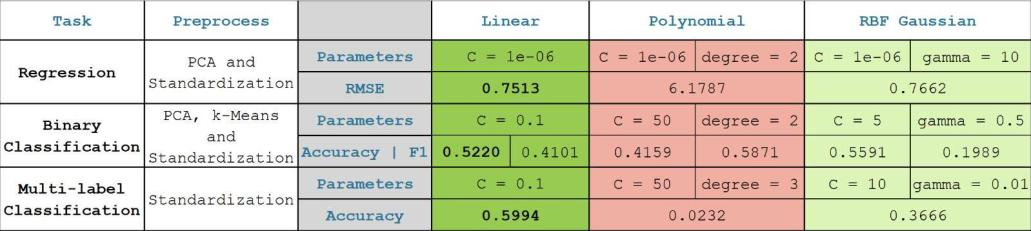

The polynomial kernel failed to outperform the benchmark scores for the three targets. This is to say that it was not able to correctly detect the trends that cause particular outputs. In consequence, this kernel is not trustworthy and must not be utilized in these tasks.

The linear kernel was the most accurate approach, followed by the RBF-Gaussian kernel. Nevertheless, the latter has the disadvantage of being meaningfully slower than the former, without being able to overpass it.

The superiority of the linear kernel in these cases does not mean that it will always be the best. As a matter of fact, it is possible that the polynomial and/or the RBF-Gaussian kernels perform better than the linear counterpart with data transfomed with techniques other than PCA and k-means.

The regression that returns the lowest RMSE on the test set has a linear kernel. However, the RBF-Gaussian is just a little bit higher. Considering both the RMSE and the running time, it is necessary to say that the linear kernel is considerably better, especially for being much faster.

The RBF-Gaussian kernel obtained the highest accuracy for Binary Classification, and it would have been the best if the corresponding F1 score was not so low. In contrast, the linear kernel got an accuracy only slightly smaller (by 0.037) and an F1 score of about twice that of the Gaussian approach.

The RBF-Gaussian kernel managed to outperform the plain technique of predicting everything with the most frequent label. Nonetheless, it is not as good as the benchmark accuracy. On the other hand, the linear kernel approach achieved an accuracy good enough to surpass both, becoming the best classifier.

## Neural Networks Implementation - Martin de Leon
 
### Introduction
 
My implementation for this project will be using neural networks. I chose this approach due to the fact that if there are any subtle patterns, the neural network should be able to adapt to them. In this line of reasoning, since neural networks are an excellent framework for any kind of prediction (regression or classification), I have decided to construct a model for each one of the three response variables we have created, to observe and conclude which one of them would be the most useful in gaining an edge to predict the price difference.
 
### Approach
 
As I did some initial tests to determine the best type of network (trying different activations, layers, etc.), it quickly became apparent that all models would continue decreasing the loss function, while the validation stagnated at a given value. This indicates overfitting, and even when applying some regularization technics, the problem would still persist. It became clear that some heavy regularization (even mixing multiple methods) would be the right move in training the model.

Thus, since neural networks have multiple configurations, the best solution would be randomizing different configurations using `keras_tuner`, and training a reduced model (randomizing 10% of y and X). Then, I will train the model that had the best performance in validation, for 200 epochs, with an early stopping condition at a patience of 100 (most models seem to reach an optimal solution over the first epochs). As mentioned, more than one regularization seems to be the right decision, so I ended up setting my tuner as follows:

* The number of hidden layers: 0 to 10
* The number of neurons per layer: 1 to 500
* Learning Rate: log sampling from 0.0001 to 0.02
* A Learning Rate Scheduler: Based on performance on validation, with a factor of 0.5
* A random choice between $\ell_1$ and $\ell_2$ regularization: with a log sampling value between 0.00001 and 100 (intuitive, since there are many features, an $\ell_1$ regularization should be a good implementation for feature selection)
* Optimizer: a choice between Nadam and Nesterov SGD (generally the best-performing optimizers)
* Activation: A choice between Leaky Relu, Gelu, or Swish (among the three, there is good flexibility to construct both a shallow or deep network, and Leaky Relu solves the dying neuron problem)
* An additional regularization: randomly selected among Batch normalization, Dropout, or no additional regularization
* In case the Dropout gets selected, a dropout probability with log sampling between 0.02 and 0.2
* I also implemented early stopping to make training faster, and further regularize the models, with a tolerance of 0.00001 (most models get close to a similar minimum value, so I did not want to stop even if it gets relatively close) and patience of 10.

This configuration should allow quickly discarding bad models and keeping the better ones for full training. Forty trials would seem to be a good number, since, through observations, most of the great models reach a plateau in validation relatively quickly, and all end up competing over minor improvements. This also explains why I choose to use only 30 epochs for each.

However, I would also like to have an additional benchmark (a shallow network benchmark) to compare the tuned model to, and see how much improvement we can achieve by all the tuning and full training. So, I will also train a Relu activation model with just one layer and 100 neurons, to serve as an additional benchmark to compare the final performance.

Finally, I needed to decide whether to add an input layer to the models. Since the data set has features with a wide range of units (decimals, thousands), and neural networks might be susceptible to this, a normalization layer at the beginning is an obvious answer.

With this in mind, let's train all the mentioned models and evaluate the results.

### Regression Analysis

#### Simple neural network

In [ ]:
import tensorflow as tf
#Added this so that the macbook runs faster on smaller batches
tf.config.set_visible_devices([], 'GPU')

#Defining the reset section function (from lecture notes)
def reset_session(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()
    
reset_session()

#Simple model
model_lr = tf.keras.Sequential()
model_lr.add(tf.keras.layers.Normalization(input_shape=X_train.shape[1:]))
model_lr.add(tf.keras.layers.Dense(100, activation='relu', kernel_initializer="he_normal"))
model_lr.add(tf.keras.layers.Dense(1))

#Nadam optimizer
optimizer = tf.keras.optimizers.legacy.Nadam(learning_rate=0.01, beta_1=0.9,
                                     beta_2=0.999)

#Early stopping for regularization
early_stopping_lr = tf.keras.callbacks.EarlyStopping(monitor = 'val_rmse', patience=50,
                                                  restore_best_weights=True)

#Learning rate scheduler for zooming into the minimum
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_rmse',
                                                    factor=0.5, patience=20)
#Compiling the model
model_lr.compile(loss="mse", optimizer=optimizer,
                  metrics=[tf.keras.metrics.RootMeanSquaredError(
    name="rmse", dtype=None
)])

#Training the shallow model
training_model_lr = model_lr.fit(X_train, y_train, epochs=200,
            validation_data=(X_valid, y_valid), callbacks=[early_stopping_lr, lr_scheduler])

Epoch 1/200
13035/13035 [==============================] - 10s 736us/step - loss: 624551.8750 - rmse: 790.2859 - val_loss: 3.3800 - val_rmse: 1.8385 - lr: 0.0100
Epoch 2/200
13035/13035 [==============================] - 9s 711us/step - loss: 233.0820 - rmse: 15.2670 - val_loss: 3.2335 - val_rmse: 1.7982 - lr: 0.0100
Epoch 3/200
13035/13035 [==============================] - 9s 708us/step - loss: 6.7061 - rmse: 2.5896 - val_loss: 3.2342 - val_rmse: 1.7984 - lr: 0.0100
Epoch 4/200
13035/13035 [==============================] - 10s 774us/step - loss: 6.6257 - rmse: 2.5740 - val_loss: 3.2335 - val_rmse: 1.7982 - lr: 0.0100
Epoch 5/200
13035/13035 [==============================] - 9s 728us/step - loss: 6.6225 - rmse: 2.5734 - val_loss: 3.2338 - val_rmse: 1.7983 - lr: 0.0100
Epoch 6/200
13035/13035 [==============================] - 9s 728us/step - loss: 6.6222 - rmse: 2.5734 - val_loss: 3.2363 - val_rmse: 1.7990 - lr: 0.0100
Epoch 7/200
13035/13035 [==============================] - 10s 7

#### Tuned neural network

In [13]:
import keras_tuner as kt

reset_session()

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=10, default=5)
    n_neurons = hp.Int("n_neurons", min_value=1, max_value=500)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=2e-2,
                             sampling="log")
    kernel_regularizer = hp.Float("kernel_regularizer", min_value=1e-5, max_value=100,
                             sampling="log")
    regularization = hp.Choice("regularization", values=["l1", "l2"])
    optimizer = hp.Choice("optimizer", values=["sgd", "Nadam"])
    activation = hp.Choice("activation", values=['leaky_relu', "gelu", "swish"])
    Additional_regularization = hp.Choice("Additional_reg", values=['Batch_Norm', 'dropout' , 'no'])
    dropout_prob = hp.Float("dropout_probability", min_value=0.02, max_value=0.20,
                             sampling="log")

    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.legacy.SGD(learning_rate = learning_rate, momentum=0.9, nesterov=True, clipnorm=1.0)
    else:
        optimizer = tf.keras.optimizers.legacy.Nadam(learning_rate=learning_rate)

    if activation == 'leaky_relu':
        activation = tf.keras.layers.LeakyReLU(alpha=0.01)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Normalization(input_shape=X_train.shape[1:]))
    
    if Additional_regularization == 'no':
        if regularization == 'l1':
            for _ in range(n_hidden):
                model.add(tf.keras.layers.Dense(n_neurons, activation=activation, kernel_initializer="he_normal",
                        kernel_regularizer=tf.keras.regularizers.l1(kernel_regularizer)))
        else:
            for _ in range(n_hidden):
                model.add(tf.keras.layers.Dense(n_neurons, activation=activation, kernel_initializer="he_normal",
                        kernel_regularizer=tf.keras.regularizers.l2(kernel_regularizer)))
    
    else:
        if Additional_regularization == 'dropout':
            if regularization == 'l1':
                for _ in range(n_hidden):
                    model.add(tf.keras.layers.Dropout(rate=dropout_prob))
                    model.add(tf.keras.layers.Dense(n_neurons, activation=activation, kernel_initializer="he_normal",
                            kernel_regularizer=tf.keras.regularizers.l1(kernel_regularizer)))
            else:
                for _ in range(n_hidden):
                    model.add(tf.keras.layers.Dropout(rate=dropout_prob))
                    model.add(tf.keras.layers.Dense(n_neurons, activation=activation, kernel_initializer="he_normal",
                            kernel_regularizer=tf.keras.regularizers.l2(kernel_regularizer)))
            model.add(tf.keras.layers.Dropout(rate=dropout_prob))
        else:
            if regularization == 'l1':
                for _ in range(n_hidden):
                    model.add(tf.keras.layers.BatchNormalization())
                    model.add(tf.keras.layers.Dense(n_neurons, activation=activation, kernel_initializer="he_normal",
                            kernel_regularizer=tf.keras.regularizers.l1(kernel_regularizer)))
            else:
                for _ in range(n_hidden):
                    model.add(tf.keras.layers.BatchNormalization())
                    model.add(tf.keras.layers.Dense(n_neurons, activation=activation, kernel_initializer="he_normal",
                            kernel_regularizer=tf.keras.regularizers.l2(kernel_regularizer)))
            model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss="mse", optimizer=optimizer,
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse", dtype=None)])
    return model

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_rmse',
                                                    factor=0.5, patience=4)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_rmse', patience=10,
                                                  restore_best_weights=True, min_delta=0.00001)

random_search_tuner_reg = kt.RandomSearch(
    build_model, objective=kt.Objective("val_rmse", direction="min"), max_trials=40, overwrite=True, seed=42)

train_index_rand = np.sort(np.random.choice(X_train.shape[0], int(np.ceil(X_train.shape[0] * 0.1)), replace=False))

X_train_red = X_train.iloc[train_index_rand,:]
y_train_red = y_train.iloc[train_index_rand]

valid_index_rand = np.sort(np.random.choice(X_valid.shape[0], int(np.ceil(X_valid.shape[0] * 0.1)), replace=False))

X_valid_red = X_valid.iloc[valid_index_rand,:]
y_valid_red = y_valid.iloc[valid_index_rand]

random_search_tuner_reg.search(X_train_red, y_train_red, epochs=30,
                           validation_data=(X_valid_red, y_valid_red), 
                           callbacks=[lr_scheduler, early_stopping_cb])

Trial 40 Complete [00h 01m 57s]
val_rmse: 1.6895802021026611

Best val_rmse So Far: 1.646568775177002
Total elapsed time: 01h 24m 41s
INFO:tensorflow:Oracle triggered exit


In [14]:
#Getting the best configuration
best_params_reg = random_search_tuner_reg.get_best_hyperparameters()[0]
params_reg = pd.DataFrame(best_params_reg.values, index=["Best hyperparameters"]).transpose()

#### Full training for the tuned model

In [16]:
best_model_regression = random_search_tuner_reg.get_best_models(num_models=1)[0]

early_stopping_rbw = tf.keras.callbacks.EarlyStopping(monitor = 'val_rmse', patience=100,
                                                  restore_best_weights=True)
lr_scheduler_rbw= tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_rmse',
                                                    factor=0.5, patience=20)

training_best_model_regression = best_model_regression.fit(X_train, y_train, epochs=200,
            validation_data=(X_valid, y_valid), callbacks=[lr_scheduler_rbw, early_stopping_rbw])

Epoch 1/200
13035/13035 [==============================] - 60s 5ms/step - loss: 6.6487 - rmse: 2.5696 - val_loss: 3.2665 - val_rmse: 1.7976 - lr: 9.7024e-04
Epoch 2/200
13035/13035 [==============================] - 58s 4ms/step - loss: 6.6365 - rmse: 2.5687 - val_loss: 3.6868 - val_rmse: 1.9100 - lr: 9.7024e-04
Epoch 3/200
13035/13035 [==============================] - 60s 5ms/step - loss: 6.6285 - rmse: 2.5681 - val_loss: 3.2577 - val_rmse: 1.7978 - lr: 9.7024e-04
Epoch 4/200
13035/13035 [==============================] - 58s 4ms/step - loss: 6.6291 - rmse: 2.5682 - val_loss: 3.2601 - val_rmse: 1.7963 - lr: 9.7024e-04
Epoch 5/200
13035/13035 [==============================] - 59s 5ms/step - loss: 6.6278 - rmse: 2.5682 - val_loss: 3.2604 - val_rmse: 1.7985 - lr: 9.7024e-04
Epoch 6/200
13035/13035 [==============================] - 57s 4ms/step - loss: 6.6228 - rmse: 2.5677 - val_loss: 3.3871 - val_rmse: 1.8316 - lr: 9.7024e-04
Epoch 7/200
13035/13035 [==============================] -

### Multi-Class Analysis

#### Simple neural network

In [17]:
reset_session()

model_class = tf.keras.Sequential()
model_class.add(tf.keras.layers.Normalization(input_shape=X_train.shape[1:]))
model_class.add(tf.keras.layers.Dense(100, activation='relu', kernel_initializer="he_normal"))
model_class.add(tf.keras.layers.Dense(5, activation = 'softmax'))

optimizer = tf.keras.optimizers.legacy.Nadam(learning_rate=0.01, beta_1=0.9,
                                     beta_2=0.999)

early_stopping_lr = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience=50,
                                                  restore_best_weights=True)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                    factor=0.5, patience=20)

model_class.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])

training_model_class = model_class.fit(X_train, y_class_train, epochs=200,
            validation_data=(X_valid, y_class_valid), callbacks=[early_stopping_lr, lr_scheduler])

Epoch 1/200
13035/13035 [==============================] - 14s 1ms/step - loss: 19.8649 - accuracy: 0.2006 - val_loss: 1.6244 - val_accuracy: 0.2283 - lr: 0.0100
Epoch 2/200
13035/13035 [==============================] - 13s 1ms/step - loss: 1.6628 - accuracy: 0.2000 - val_loss: 1.6162 - val_accuracy: 0.1138 - lr: 0.0100
Epoch 3/200
13035/13035 [==============================] - 13s 1ms/step - loss: 1.6102 - accuracy: 0.2015 - val_loss: 1.6145 - val_accuracy: 0.1134 - lr: 0.0100
Epoch 4/200
13035/13035 [==============================] - 13s 1ms/step - loss: 1.6102 - accuracy: 0.2004 - val_loss: 1.5979 - val_accuracy: 0.3266 - lr: 0.0100
Epoch 5/200
13035/13035 [==============================] - 15s 1ms/step - loss: 1.6102 - accuracy: 0.2017 - val_loss: 1.6068 - val_accuracy: 0.1138 - lr: 0.0100
Epoch 6/200
13035/13035 [==============================] - 12s 940us/step - loss: 1.6103 - accuracy: 0.2005 - val_loss: 1.6058 - val_accuracy: 0.2283 - lr: 0.0100
Epoch 7/200
13035/13035 [======

#### Tuned neural network

In [18]:
reset_session()

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=10, default=5)
    n_neurons = hp.Int("n_neurons", min_value=1, max_value=500)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=2e-2,
                             sampling="log")
    kernel_regularizer = hp.Float("kernel_regularizer", min_value=1e-5, max_value=100,
                             sampling="log")
    regularization = hp.Choice("regularization", values=["l1", "l2"])
    optimizer = hp.Choice("optimizer", values=["sgd", "Nadam"])
    activation = hp.Choice("activation", values=['leaky_relu', "gelu", "swish"])
    Additional_regularization = hp.Choice("Additional_reg", values=['Batch_Norm', 'dropout' , 'no'])
    dropout_prob = hp.Float("dropout_probability", min_value=0.02, max_value=0.20,
                             sampling="log")

    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.legacy.SGD(learning_rate = learning_rate, momentum=0.9, nesterov=True, clipnorm=1.0)
    else:
        optimizer = tf.keras.optimizers.legacy.Nadam(learning_rate=learning_rate)

    if activation == 'leaky_relu':
        activation = tf.keras.layers.LeakyReLU(alpha=0.01)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Normalization(input_shape=X_train.shape[1:]))
    
    if Additional_regularization == 'no':
        if regularization == 'l1':
            for _ in range(n_hidden):
                model.add(tf.keras.layers.Dense(n_neurons, activation=activation, kernel_initializer="he_normal",
                        kernel_regularizer=tf.keras.regularizers.l1(kernel_regularizer)))
        else:
            for _ in range(n_hidden):
                model.add(tf.keras.layers.Dense(n_neurons, activation=activation, kernel_initializer="he_normal",
                        kernel_regularizer=tf.keras.regularizers.l2(kernel_regularizer)))
    
    else:
        if Additional_regularization == 'dropout':
            if regularization == 'l1':
                for _ in range(n_hidden):
                    model.add(tf.keras.layers.Dropout(rate=dropout_prob))
                    model.add(tf.keras.layers.Dense(n_neurons, activation=activation, kernel_initializer="he_normal",
                            kernel_regularizer=tf.keras.regularizers.l1(kernel_regularizer)))
            else:
                for _ in range(n_hidden):
                    model.add(tf.keras.layers.Dropout(rate=dropout_prob))
                    model.add(tf.keras.layers.Dense(n_neurons, activation=activation, kernel_initializer="he_normal",
                            kernel_regularizer=tf.keras.regularizers.l2(kernel_regularizer)))
            model.add(tf.keras.layers.Dropout(rate=dropout_prob))
        else:
            if regularization == 'l1':
                for _ in range(n_hidden):
                    model.add(tf.keras.layers.BatchNormalization())
                    model.add(tf.keras.layers.Dense(n_neurons, activation=activation, kernel_initializer="he_normal",
                            kernel_regularizer=tf.keras.regularizers.l1(kernel_regularizer)))
            else:
                for _ in range(n_hidden):
                    model.add(tf.keras.layers.BatchNormalization())
                    model.add(tf.keras.layers.Dense(n_neurons, activation=activation, kernel_initializer="he_normal",
                            kernel_regularizer=tf.keras.regularizers.l2(kernel_regularizer)))
            model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dense(5, activation = 'softmax'))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                    factor=0.5, patience=4)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience=10,
                                                  restore_best_weights=True, min_delta=0.001)

random_search_tuner_class = kt.RandomSearch(
    build_model, objective=kt.Objective("val_accuracy", direction="max"), max_trials=40, overwrite=True, seed=43)

train_index_rand = np.sort(np.random.choice(X_train.shape[0], int(np.ceil(X_train.shape[0] * 0.1)), replace=False))

X_train_red = X_train.iloc[train_index_rand,:]
y_class_train_red = y_class_train.iloc[train_index_rand]

valid_index_rand = np.sort(np.random.choice(X_valid.shape[0], int(np.ceil(X_valid.shape[0] * 0.1)), replace=False))

X_valid_red = X_valid.iloc[valid_index_rand,:]
y_class_valid_red = y_class_valid.iloc[valid_index_rand]

random_search_tuner_class.search(X_train_red, y_class_train_red, epochs=30,
                           validation_data=(X_valid_red, y_class_valid_red), 
                           callbacks=[lr_scheduler, early_stopping_cb])

Trial 40 Complete [00h 02m 40s]
val_accuracy: 0.3193325698375702

Best val_accuracy So Far: 0.36612963676452637
Total elapsed time: 01h 23m 00s
INFO:tensorflow:Oracle triggered exit


In [19]:
best_params_class = random_search_tuner_class.get_best_hyperparameters()[0]
params_class = pd.DataFrame(best_params_class.values, index=["Best hyperparameters"]).transpose()

#### Full training for the tuned model

In [20]:
best_model_classes = random_search_tuner_class.get_best_models(num_models=1)[0]

early_stopping_cbw = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience=100,
                                                  restore_best_weights=True)
lr_scheduler_cbw= tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                    factor=0.5, patience=20)

training_best_model_classes = best_model_classes.fit(X_train, y_class_train, epochs=200,
            validation_data=(X_valid, y_class_valid), callbacks=[lr_scheduler_cbw, early_stopping_cbw])

Epoch 1/200
13035/13035 [==============================] - 42s 3ms/step - loss: 1.7252 - accuracy: 0.2811 - val_loss: 1.5826 - val_accuracy: 0.3601 - lr: 0.0031
Epoch 2/200
13035/13035 [==============================] - 40s 3ms/step - loss: 1.7228 - accuracy: 0.2825 - val_loss: 1.6842 - val_accuracy: 0.3500 - lr: 0.0031
Epoch 3/200
13035/13035 [==============================] - 40s 3ms/step - loss: 1.7210 - accuracy: 0.2819 - val_loss: 1.6276 - val_accuracy: 0.3569 - lr: 0.0031
Epoch 4/200
13035/13035 [==============================] - 40s 3ms/step - loss: 1.7228 - accuracy: 0.2823 - val_loss: 1.6927 - val_accuracy: 0.3631 - lr: 0.0031
Epoch 5/200
13035/13035 [==============================] - 40s 3ms/step - loss: 1.7218 - accuracy: 0.2822 - val_loss: 1.8019 - val_accuracy: 0.3574 - lr: 0.0031
Epoch 6/200
13035/13035 [==============================] - 40s 3ms/step - loss: 1.7181 - accuracy: 0.2826 - val_loss: 1.6929 - val_accuracy: 0.3571 - lr: 0.0031
Epoch 7/200
13035/13035 [=========

### Binary Analysis

#### Simple neural network

In [21]:
reset_session()

model_binary = tf.keras.Sequential()
model_binary.add(tf.keras.layers.Normalization(input_shape=X_train.shape[1:]))
model_binary.add(tf.keras.layers.Dense(100, activation='relu', kernel_initializer="he_normal"))
model_binary.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

#I am using the legacy optimizer, since the new one has a conflict with M1 macs. It is the same as using the regular optimizer
optimizer = tf.keras.optimizers.legacy.Nadam(learning_rate=0.01, beta_1=0.9,
                                     beta_2=0.999)

early_stopping_binary = tf.keras.callbacks.EarlyStopping(monitor = 'val_auc', patience=50,
                                                  restore_best_weights=True)

lr_scheduler_binary = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_auc',
                                                    factor=0.5, patience=20)

model_binary.compile(loss="binary_crossentropy", optimizer=optimizer,
                  metrics=["AUC"])

training_model_binary = model_binary.fit(X_train, y_binary_train, epochs=200,
            validation_data=(X_valid, y_binary_valid), callbacks=[early_stopping_binary, lr_scheduler_binary])

Epoch 1/200
13035/13035 [==============================] - 11s 808us/step - loss: 9.4495 - auc: 0.4996 - val_loss: 0.6907 - val_auc: 0.5000 - lr: 0.0100
Epoch 2/200
13035/13035 [==============================] - 10s 764us/step - loss: 0.6951 - auc: 0.4996 - val_loss: 0.6911 - val_auc: 0.5000 - lr: 0.0100
Epoch 3/200
13035/13035 [==============================] - 10s 773us/step - loss: 0.6935 - auc: 0.5011 - val_loss: 0.6905 - val_auc: 0.5000 - lr: 0.0100
Epoch 4/200
13035/13035 [==============================] - 10s 775us/step - loss: 0.6928 - auc: 0.4999 - val_loss: 0.6903 - val_auc: 0.5000 - lr: 0.0100
Epoch 5/200
13035/13035 [==============================] - 10s 781us/step - loss: 0.6928 - auc: 0.5011 - val_loss: 0.6921 - val_auc: 0.5000 - lr: 0.0100
Epoch 6/200
13035/13035 [==============================] - 10s 788us/step - loss: 0.6927 - auc: 0.5008 - val_loss: 0.6909 - val_auc: 0.5000 - lr: 0.0100
Epoch 7/200
13035/13035 [==============================] - 10s 788us/step - loss: 

#### Tuned neural network
 
Different from the other models (which did not have this problem), I have decided to address the problem of unbalanced classes for the binary classification. Since both the training set and validation set have more observations of class 0 than class 1, I will up weight class 1 for the tuning and full training, so that the model is more likely to predict both classes in similar proportions, and not just resort to predicting the same class, leading to a biased model. Also, instead of using accuracy, I will measure AUC.

The decision for the weight has been made using trial and error, and 1.125 seem to be the best option, since weights higher would result in mainly predicting class 1, and lower in mostly predicting 0.

Using F1 as the metric could have also been a choice, but through trial and error, it wouldn't outperform AUC, and if included with the weights, it would almost always lead to a model that mostly predicted class 1 for all observations.

In [29]:
reset_session()

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=10, default=5)
    n_neurons = hp.Int("n_neurons", min_value=1, max_value=500)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=2e-2,
                             sampling="log")
    kernel_regularizer = hp.Float("kernel_regularizer", min_value=1e-5, max_value=100,
                             sampling="log")
    regularization = hp.Choice("regularization", values=["l1", "l2"])
    optimizer = hp.Choice("optimizer", values=["sgd", "Nadam"])
    activation = hp.Choice("activation", values=['leaky_relu', "gelu", "swish"])
    Additional_regularization = hp.Choice("Additional_reg", values=['Batch_Norm', 'dropout' , 'no'])
    dropout_prob = hp.Float("dropout_probability", min_value=0.02, max_value=0.20,
                             sampling="log")
    
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.legacy.SGD(learning_rate = learning_rate, momentum=0.9, nesterov=True, clipnorm=1.0)
    else:
        optimizer = tf.keras.optimizers.legacy.Nadam(learning_rate=learning_rate)

    if activation == 'leaky_relu':
        activation = tf.keras.layers.LeakyReLU(alpha=0.01)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Normalization(input_shape=X_train.shape[1:]))
    
    if Additional_regularization == 'no':
        if regularization == 'l1':
            for _ in range(n_hidden):
                model.add(tf.keras.layers.Dense(n_neurons, activation=activation, kernel_initializer="he_normal",
                        kernel_regularizer=tf.keras.regularizers.l1(kernel_regularizer)))
        else:
            for _ in range(n_hidden):
                model.add(tf.keras.layers.Dense(n_neurons, activation=activation, kernel_initializer="he_normal",
                        kernel_regularizer=tf.keras.regularizers.l2(kernel_regularizer)))
    
    else:
        if Additional_regularization == 'dropout':
            if regularization == 'l1':
                for _ in range(n_hidden):
                    model.add(tf.keras.layers.Dropout(rate=dropout_prob))
                    model.add(tf.keras.layers.Dense(n_neurons, activation=activation, kernel_initializer="he_normal",
                            kernel_regularizer=tf.keras.regularizers.l1(kernel_regularizer)))
            else:
                for _ in range(n_hidden):
                    model.add(tf.keras.layers.Dropout(rate=dropout_prob))
                    model.add(tf.keras.layers.Dense(n_neurons, activation=activation, kernel_initializer="he_normal",
                            kernel_regularizer=tf.keras.regularizers.l2(kernel_regularizer)))
            model.add(tf.keras.layers.Dropout(rate=dropout_prob))
        else:
            if regularization == 'l1':
                for _ in range(n_hidden):
                    model.add(tf.keras.layers.BatchNormalization())
                    model.add(tf.keras.layers.Dense(n_neurons, activation=activation, kernel_initializer="he_normal",
                            kernel_regularizer=tf.keras.regularizers.l1(kernel_regularizer)))
            else:
                for _ in range(n_hidden):
                    model.add(tf.keras.layers.BatchNormalization())
                    model.add(tf.keras.layers.Dense(n_neurons, activation=activation, kernel_initializer="he_normal",
                            kernel_regularizer=tf.keras.regularizers.l2(kernel_regularizer)))
            model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
    model.compile(loss="binary_crossentropy", optimizer=optimizer,
                  metrics=["AUC"])
    return model

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_auc',
                                                    factor=0.5, patience=4)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_auc', patience=10,
                                                  restore_best_weights=True, min_delta=0.001)

random_search_tuner_binary = kt.RandomSearch(
    build_model, objective=kt.Objective("val_auc", direction="max"), max_trials=40, overwrite=True, seed=44)

#Overweighing class 1 just a bit to balance the disparity
weight_binary = {0: 1, 1: 1.125}

train_index_rand = np.sort(np.random.choice(X_train.shape[0], int(np.ceil(X_train.shape[0] * 0.1)), replace=False))

X_train_red = X_train.iloc[train_index_rand,:]
y_binary_train_red = y_binary_train.iloc[train_index_rand]

valid_index_rand = np.sort(np.random.choice(X_valid.shape[0], int(np.ceil(X_valid.shape[0] * 0.1)), replace=False))

X_valid_red = X_valid.iloc[valid_index_rand,:]
y_binary_valid_red = y_binary_valid.iloc[valid_index_rand]

random_search_tuner_binary.search(X_train_red, y_binary_train_red, epochs=30,
                           validation_data=(X_valid_red, y_binary_valid_red), 
                           callbacks=[lr_scheduler, early_stopping_cb], class_weight=weight_binary)

Trial 40 Complete [00h 00m 20s]
val_auc: 0.5172024965286255

Best val_auc So Far: 0.5388955473899841
Total elapsed time: 00h 54m 29s
INFO:tensorflow:Oracle triggered exit


In [30]:
best_params_binary = random_search_tuner_binary.get_best_hyperparameters()[0]
params_binary = pd.DataFrame(best_params_binary.values, index=["Best hyperparameters"]).transpose()

#### Full training for the tuned model

In [31]:
best_model_binary = random_search_tuner_binary.get_best_models(num_models=1)[0]

early_stopping_bbw = tf.keras.callbacks.EarlyStopping(monitor = 'val_auc', patience=100,
                                                  restore_best_weights=True)
lr_scheduler_bbw= tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_auc',
                                                    factor=0.5, patience=20)

training_best_model_binary = best_model_binary.fit(X_train, y_binary_train, epochs=200,
            validation_data=(X_valid, y_binary_valid), callbacks=[lr_scheduler_bbw, early_stopping_bbw], class_weight=weight_binary)

Epoch 1/200
13035/13035 [==============================] - 166s 13ms/step - loss: 1.8893 - auc: 0.5139 - val_loss: 1.3919 - val_auc: 0.5200 - lr: 0.0055
Epoch 2/200
13035/13035 [==============================] - 163s 13ms/step - loss: 1.1461 - auc: 0.5139 - val_loss: 0.9665 - val_auc: 0.5185 - lr: 0.0055
Epoch 3/200
13035/13035 [==============================] - 165s 13ms/step - loss: 0.8368 - auc: 0.5157 - val_loss: 0.7209 - val_auc: 0.5292 - lr: 0.0055
Epoch 4/200
13035/13035 [==============================] - 164s 13ms/step - loss: 0.7443 - auc: 0.5359 - val_loss: 0.6960 - val_auc: 0.5424 - lr: 0.0055
Epoch 5/200
13035/13035 [==============================] - 165s 13ms/step - loss: 0.7358 - auc: 0.5389 - val_loss: 0.6956 - val_auc: 0.5449 - lr: 0.0055
Epoch 6/200
13035/13035 [==============================] - 170s 13ms/step - loss: 0.7345 - auc: 0.5419 - val_loss: 0.6938 - val_auc: 0.5453 - lr: 0.0055
Epoch 7/200
13035/13035 [==============================] - 167s 13ms/step - loss: 

### Final Models and metrics

#### Best hyperparameters for all three problems

In [47]:
Final_Tuning = params_reg.join(params_class, lsuffix='1', rsuffix='2').join(params_binary).set_axis(
['Best hyperparameters - Regression','Best hyperparameters - Multi-class', 'Best hyperparameters - Binary'],axis=1)
Final_Tuning

,Best hyperparameters - Regression,Best hyperparameters - Multi-class,Best hyperparameters - Binary
n_hidden,2,4,9
n_neurons,448,223,429
learning_rate,0.007762,0.006134,0.011072
kernel_regularizer,0.000479,0.058527,0.000048
regularization,l2,l1,l1
optimizer,Nadam,sgd,sgd
activation,gelu,gelu,gelu
Additional_reg,Batch_Norm,Batch_Norm,Batch_Norm
dropout_probability,0.064721,0.090092,0.116364


After tuning, we notice some interesting observations. All three models ended up with a Gelu activation and batch normalization as the additional regularization (dropout_probability should not be considered since none of the models have dropout). Classification models choose the l1 penalty, which automatically makes feature selection (the dataset has 479 features, so intuitively, an l1 penalty seems the best decision).

Among all models, binary classification is the most complicated one (9 layers with 429 neurons each), and also has a surprisingly high learning rate (we still need to remember that there was a learning rate schedule). Regression is the simpler one, with only two hidden layers, while the multi-class has four.

Now, let's compare their performance, and see if the tuning helps them beat the benchmarks we have set up.

#### Performance metrics for all models

In [33]:
y_test_pred_1 = model_lr.predict(X_test) > 0
y_test_pred_2 = best_model_regression.predict(X_test) > 0
y_test_pred_3 = np.argmax(model_class.predict(X_test), axis = 1)
y_test_pred_4 = np.argmax(best_model_classes.predict(X_test), axis = 1)
y_test_pred_5 = model_binary.predict(X_test)>0.5
y_test_pred_6 = best_model_binary.predict(X_test)>0.5

1630/1630 [==============================] - 4s 2ms/step


In [34]:
## Regression
#Simple Reg
rmse_sr = model_lr.evaluate(X_test, y_test)[1]
#Tuned Reg
rmse_tr = best_model_regression.evaluate(X_test, y_test)[1]

## Classes
#Simple Class
acc_sc = model_class.evaluate(X_test, y_class_test)[1]
#Tuned Class
acc_tc = best_model_classes.evaluate(X_test, y_class_test)[1]

## Binary
#Simple Binary
acc_sb = accuracy_score(y_binary_test, model_binary.predict(X_test)>0.5)
#Tuned Binary
acc_tb = accuracy_score(y_binary_test, best_model_binary.predict(X_test)>0.5)

#Final scores table
Final_perf_scores = np.array([[rmse, rmse_sr, rmse_tr],
          [accuracy_class, acc_sc, acc_tc],
          [accuracy_binary, acc_sb, acc_tb]])

names_prob = ['Regression', 'Classification - Multi-class', 'Classification - Binary']
names_messures = ['RMSE/Accuracy Benchmark', 'RMSE/Accuracy Simple model', 'RMSE/Accuracy Tuned model']

pd.DataFrame(Final_perf_scores, index=names_prob, columns=names_messures)

1630/1630 [==============================] - 3s 2ms/step


,RMSE/Accuracy Benchmark,RMSE/Accuracy Simple model,RMSE/Accuracy Tuned model
Regression,1.074030,0.751348,0.750513
Classification - Multi-class,0.481290,0.598980,0.599440
Classification - Binary,0.512918,0.584192,0.570382


For regression, we can see that our tuned model beat both the simple model presented and the shallow neural network model (though its root mean squared error is barely better than the shallow model). And a rmse of 0.75 is not bad for price changes, so I argue that the model has some information and predictive power. However, we also need to keep in mind that the main objective of the project is to try and predict the price to develop an arbitrage, and thus rmse might not be the best to judge the regression performance in creating said strategy. In the following section, I will evaluate the regression performance in predicting negative and positive price moves.

The multi-class model is similar to the regression model in that it beats both the simple model and the shallow network, but the latter only by a minimum amount. So the model has some prediction power (taking the numbers at face value, it is an incredible performance, 60% when by guessing we would expect only a 20% accuracy). However, we need to remember that the classes for the validation and test set are unbalanced, so accuracy on its own isn't a good indicator of performance, and even then, it could be the case that the model predictions aren't that helpful in creating a trading strategy.

Finally, the binary classification model differs from the others in that even though both beat the simple benchmark, this time the shallow model has a higher prediction than the tuned model, indicating that tuning and class up weighting didn't have any effect. However, again we need to remember the data's incredibly unbalanced nature, especially the test set for the binary classification. Thus, measures other than accuracy might better determine the most useful model.

There are arguments to dive deeper into all three problems. Thus, to gain a general idea of how each model performs, I will present the confusion matrix comparison between the shallow and tuned models. This should shed some light on the models' performance and provide further information to help us decide on the optimal model to use, and if it is functional.

#### Confusion Matrix Comparison

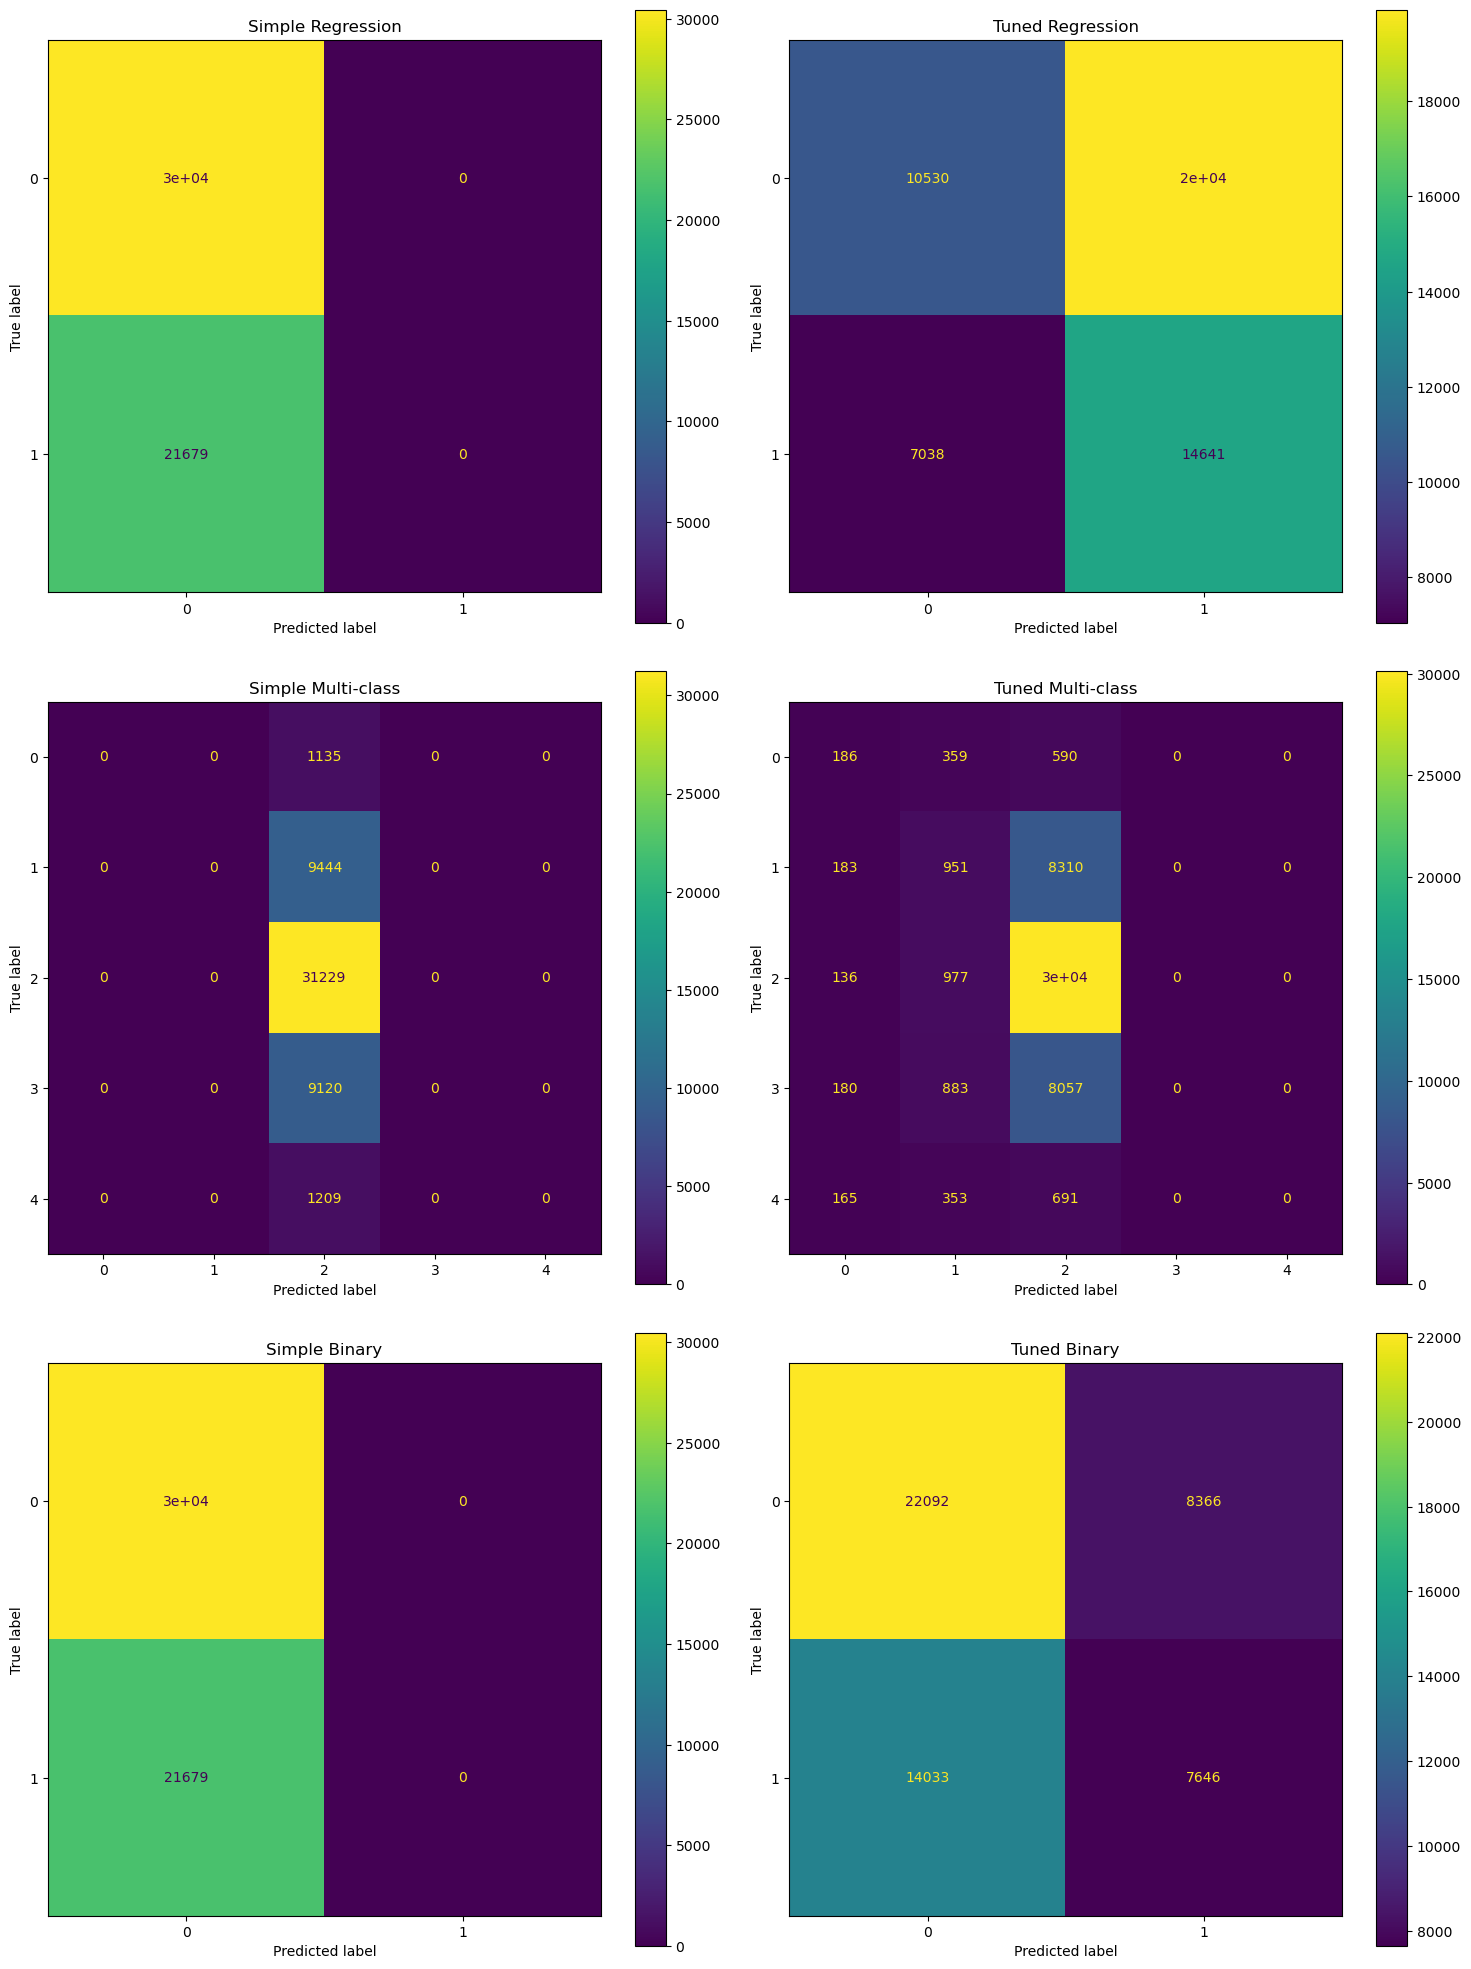

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

predictions = [y_test_pred_1, y_test_pred_2, y_test_pred_3, y_test_pred_4, y_test_pred_5, y_test_pred_6]
comparisons = [y_binary_test, y_binary_test, y_class_test, y_class_test, y_binary_test, y_binary_test]
names_conf = ['Simple Regression', 'Tuned Regression', 'Simple Multi-class', 'Tuned Multi-class', 'Simple Binary', 'Tuned Binary']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,20))

for pred, comp, ax, names in zip(predictions, comparisons, axes.flatten(), names_conf):
    ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(comp, pred)).plot(ax=ax)
    ax.title.set_text(names)
plt.tight_layout()
plt.show()

The first interesting conclusion is that all shallow models have just decided to predict the same class on the test set (regression and binary classification class 0, multi-class classification class 2), which is also the most common class in the validation set. Thus, it could be the case that the training led to them predicting the same class all the time, regardless of the features provided, which might pose a problem if we decided to implement said models going forward. Given this conclusion, all shallow models are not reliable enough to be implemented in a trading strategy.

The tuned models, on the other hand, seem to be more balanced in their predictions, so let's evaluate them one by one:

- Linear regression is predicting predominantly class 1, but the accuracy of each of the predictions seems like it could be better. A deeper classification evaluation might be warranted to attest to the usefulness of the model in a trading strategy

- Multi-class classification mainly predicts class 2, the most predominant class in the test set. However, it is not predicting a single observation as class 3 or class 4. So, even though we have great accuracy, I am just not confident in the model performance in the future to develop a new trading strategy. Furthermore, accuracy on classes 0 and 4 is not that good, and in the context of a trading strategy, those are the ones you would be most interested in, since signals of a big move can result in a more significant profit. Finally, since class 2 has positive and negative values, having great accuracy in that class is not helpful for trading.

- Binary classification seems to be the most robust model of them all. As mentioned, its accuracy is lower than that of the simple model, but the simple model seems to predict class 0 regardless of the features, and it has good performance on the test set due to the unbalance of classes. The up weighting of class 1 seemed to work, and combined with the more complex model, we see more balanced predictions. I would argue that the binary classification model is the most useful in developing a trading strategy, but we can compare other evaluation metrics to know for sure.

Since the multi-class classification model is impractical, we will discard it and focus on both the linear regression and the binary classification. Using the Sklearn classification report function, we can get deeper metrics for both, and compare them side by side. I will also include the shallow models and the benchmark binary classification report mentioned previously.

#### Classification report for Regression and Binary classification

In [49]:
from sklearn.metrics import classification_report

print("Classification report for binary target Benchmark: \n",classification_report(y_binary_test, y_binary_pred_t_1),"\n")

print("Simple Regression Model: \n",classification_report(y_binary_test, y_test_pred_1),"\n")

print("Tuned Regression Model: \n",classification_report(y_binary_test, y_test_pred_2),"\n")

print("Simple Binary Model: \n",classification_report(y_binary_test, y_test_pred_5),"\n")

print("Tuned Binary Model: \n",classification_report(y_binary_test, y_test_pred_6))

Classification report for binary target Benchmark: 
               precision    recall  f1-score   support

           0       0.58      0.58      0.58     30458
           1       0.41      0.41      0.41     21679

    accuracy                           0.51     52137
   macro avg       0.50      0.50      0.50     52137
weighted avg       0.51      0.51      0.51     52137
 

Simple Regression Model: 
               precision    recall  f1-score   support

           0       0.58      1.00      0.74     30458
           1       0.00      0.00      0.00     21679

    accuracy                           0.58     52137
   macro avg       0.29      0.50      0.37     52137
weighted avg       0.34      0.58      0.43     52137
 

Tuned Regression Model: 
               precision    recall  f1-score   support

           0       0.60      0.35      0.44     30458
           1       0.42      0.68      0.52     21679

    accuracy                           0.48     52137
   macro avg      

With these reports, we have more information about all the models. Some of the most meaningful conclusions are:

- Both the simple regression and the simple binary classification model predict everything as class 0, and as a result, the F1 is the highest for class 0 (74%), but the lowest for class 1 (0). This leads to the lowest weighted avg F1 score of 37%. Furthermore, weighted precision is also the lowest (34%). Thus, I reaffirm my viewpoint that they are not good models for trading strategies.

- The tuned regression model has high precision on class 0, but low recall, meaning the F1 score is overall low. When predicting class 1, precision is higher than the benchmark, but recall is overall good. Weighted avg F1 is lower than the benchmark, as well as overall accuracy (51% on benchmark vs. 48% on tuned regression). However, when building a trading strategy, we are looking for higher precision, since we do not need to act on all outputs of the model, only those where the model is confident. Thus, even though accuracy and F1 are better on the benchmark, I would still choose the tuned regression model between those two, since higher precision on class 0 (60% vs. 58%) means that we can develop a strategy that only acts on predictions of 0.

- Finally, when evaluating the tuned binary model, we can see that it is far superior to the other models. As mentioned in the previous point, between the classification benchmark and the tuned regression, I would pick the tuned regression due to the precision on class 0. The binary model beats that precision (61% vs. 60%) while having over twice the recall (73% vs. 35%), meaning more opportunities to execute trades. For a trading strategy to work, having an edge is just the first step, but to leverage that edge, we need to have the opportunity to trade enough times such that there is a low likelihood of losses. The F1 also reflects the advantage of this model over the others. It also has higher precision on class 1 (48%) than all the other models

Based on this, the tuned binary classification is the most useful model for developing a trading strategy. So, as a final check, we can see the training curve, ROC, and precision vs recall graph.

#### Binary Classification Training

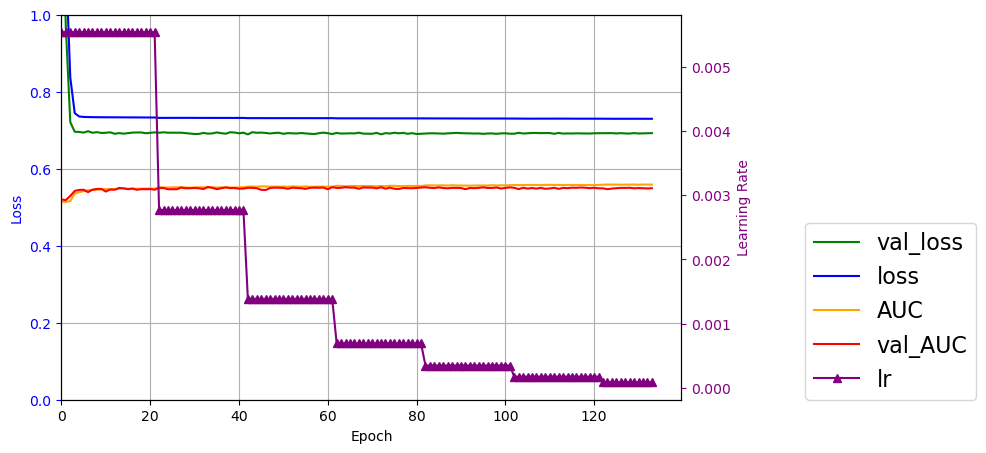

In [40]:
plt.figure(figsize=(8,5))
ln1=plt.plot(training_best_model_binary.epoch, training_best_model_binary.history["val_loss"], "g-", label='val_loss')
ln2=plt.plot(training_best_model_binary.epoch, training_best_model_binary.history["loss"], "b-", label='loss')
ln3=plt.plot(training_best_model_binary.epoch, training_best_model_binary.history["auc"], "-", color='orange', label='AUC')
ln4=plt.plot(training_best_model_binary.epoch, training_best_model_binary.history["val_auc"], "r-", label='val_AUC')
plt.xlabel("Epoch")
plt.ylabel("Loss", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, None)
plt.gca().set_ylim(0, 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ln5 = ax2.plot(training_best_model_binary.epoch, training_best_model_binary.history["lr"], "^-", color='purple', label='lr')
ax2.set_ylabel("Learning Rate", color='purple')
ax2.tick_params('y', colors='purple')

lns = ln1+ln2+ln3+ln4+ln5
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc=(1.2,0), fontsize=16)
plt.show()

Though there is a difference between the loss and the val loss, we must remember the difference in classes. However, the AUC of both appears to be the same, except towards the last epochs, where we start seeing a little overfitting. But, thanks to the early stopping, we return to the weights that are not overfitting. The learning rate scheduler seems to be performing as expected. We can look at the ROC curve and precision vs. recall graphs to explore additional insights, such as the possibility of changing the threshold to increase the trading performance of the model.

#### Binary Classification ROC Curve and Precision vs Recall curve

##### Validation ROC curve

1630/1630 [==============================] - 4s 2ms/step

The ROC AUC score for the validation set is = 0.5527252115725978



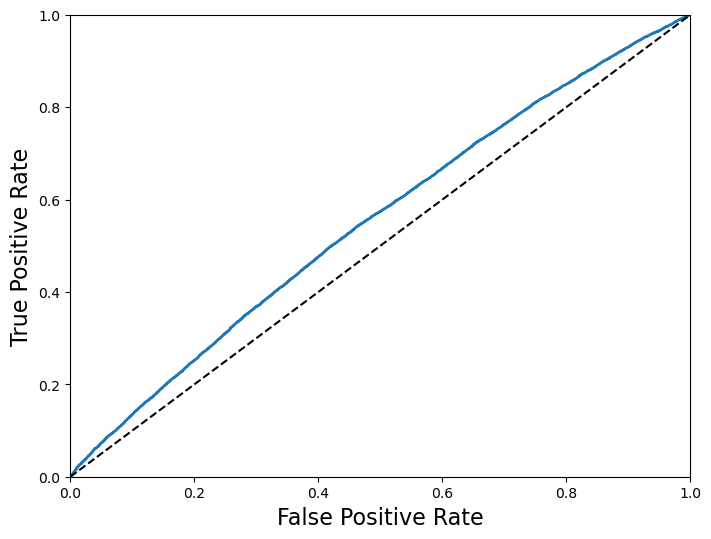

In [60]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

predicitons_best_model_valid = best_model_binary.predict(X_valid)

fpr, tpr, thresholds = roc_curve(y_binary_valid, predicitons_best_model_valid)

auc_score = roc_auc_score(y_binary_valid, predicitons_best_model_valid)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

print('\nThe ROC AUC score for the validation set is = {}\n'.format(auc_score))
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

##### Validation precision vs recall curve

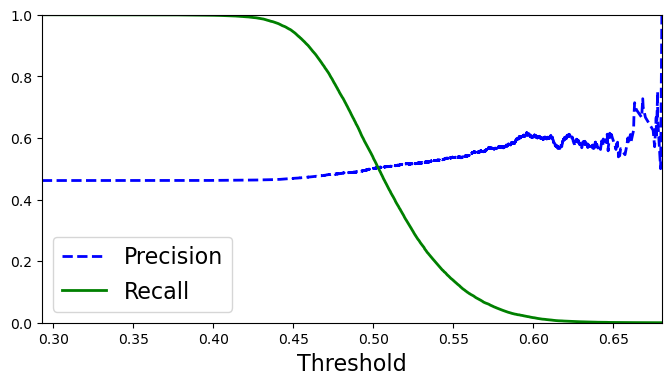

In [61]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_binary_valid, predicitons_best_model_valid)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="lower left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([thresholds.min(), thresholds.max()])
plt.show()

##### Test ROC curve

1630/1630 [==============================] - 4s 2ms/step

The ROC AUC score for the test set is = 0.5631266814523122



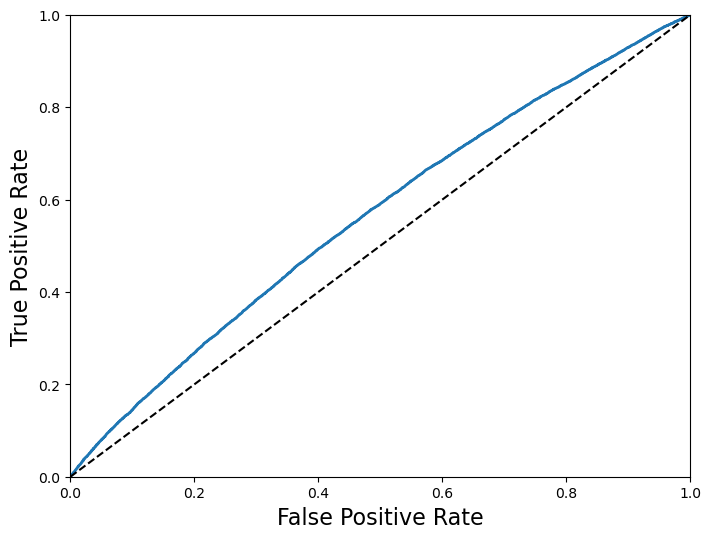

In [62]:
predicitons_best_model_test = best_model_binary.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_binary_test, predicitons_best_model_test)

auc_score = roc_auc_score(y_binary_test, predicitons_best_model_test)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

print('\nThe ROC AUC score for the test set is = {}\n'.format(auc_score))
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

ROC for both test and validation are similar; tough AUC for test data is better. Precision vs. recall would indicate that increasing the threshold would result in a minimal precision gain, while resulting in a high decrease in recall. Thus, I would argue against increasing the threshold, since the little increase in precision would result in the model predicting much fewer times.

As previously mentioned, to take advantage of such a tiny edge, we need to execute a high number of trades to minimize the probability of a loss, and a lower recall would mean fewer trades overall.

#### Final conclusions

As a final conclusion to the neural network implementation, I would say that the approach overall was a success. All the models are better than just the simple predictions benchmarks, and have an edge over simply guessing. Tuning on all three target variables seemed to improve the depth of the predictions, and overall was better than just simple shallow models. However, multi-class classification is the least useful in terms of possible applications to a trading strategy to gain an edge. In contrast, regression and binary classification are good to use, the latter being the best.

In terms of how I would use it, I would leverage the fact that the model has reasonable prediction confidence for class 0, and thus wait till it predicts a class 0 in the next minute, and then short a tiny amount in Ethereum, and as it goes down exit the trade. Given the good recall, it should predict most of the 0, and because of the high precision, I should be able to repeat the operation multiple times, reducing the risk of losses due to a bad draw. If I was not confident with shorting, we could increase the threshold barely, and even though we would have much fewer predictions of class 1, the model would have an edge in predicting a positive price change. We could buy a small amount when the model predicts an upward move, and sell our position as soon as we see it. 

Of course, both of these strategies assume relatively low skewness in the units of the change (on average, when it goes down or up, it does in similar magnitude, and not on a more considerable magnitude for either class 0 or class 1), which could pose a problem for our strategy. Still, depending on the sign of the skewness, the model could be adapted to only buy towards that class, increasing the effectiveness.

We also need to recognize the limitations, since the crypto market has periods of incredibly high volatility. Thus it would be a good idea to test the model in these scenarios to see how well it can adapt.

Overall, neural networks are a good approach to the problem at hand, and through the different metrics presented, there appears to be evidence that minute-to-minute prices are not entirely random, and there are minor miss-prices that we could exploit for a profit.